In [ ]:
!pip install hypll geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import geoopt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Import hypll library
from hypll.manifolds.poincare_ball import PoincareBall, Curvature
from hypll.tensors.manifold_tensor import ManifoldTensor
from hypll.tensors import TangentTensor
import hypll.nn as hnn

# Setup
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

Using device: cpu



## Dataset

In [ ]:

# ============================================================================
# DATASET
# ============================================================================
class IntervalDataset(Dataset):
    """
    Generate hierarchical interval pairs for contrastive learning.

    For each sample:
    - Anchor: interval [i, j] where i, j are from N equidistant points in [0, 1]
    - Positive: subinterval [i_pos, j_pos] where i <= i_pos <= j_pos <= j
    - Negatives: intervals that are NOT subintervals of [i, j]

    Special cases included:
    - Endpoints [i, i] and [j, j] as positives (atomic states)
    """

    def __init__(self, num_samples=10000, num_negatives=5, num_points=100, seed=0, endpoint_prob=0.2):
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.num_samples = num_samples
        self.num_negatives = num_negatives
        self.num_points = num_points
        self.endpoint_prob = endpoint_prob

        # Create grid of N equidistant points in [0, 1]
        self.grid = torch.linspace(0, 1, num_points)

        # Pre-generate all samples for consistency
        self.anchors = []
        self.positives = []
        self.negatives_list = []

        for _ in range(num_samples):
            # Sample anchor interval [i, j] using discrete indices
            j_idx = torch.randint(0, num_points, (1,)).item()
            i_idx = torch.randint(0, j_idx + 1, (1,)).item()  # i_idx uniformly in [0, j_idx]

            i = self.grid[i_idx].item()
            j = self.grid[j_idx].item()

            # Sample positive (subinterval)
            if torch.rand(1).item() < self.endpoint_prob:
                # With probability endpoint_prob, sample an endpoint
                if torch.rand(1).item() < 0.5:
                    # Left endpoint [i, i]
                    i_pos, j_pos = i, i
                else:
                    # Right endpoint [j, j]
                    i_pos, j_pos = j, j
            else:
                # Sample uniformly within grid points [i_idx, j_idx]
                j_pos_idx = torch.randint(i_idx, j_idx + 1, (1,)).item()
                i_pos_idx = torch.randint(i_idx, j_pos_idx + 1, (1,)).item()

                i_pos = self.grid[i_pos_idx].item()
                j_pos = self.grid[j_pos_idx].item()

            # Sample negatives (NOT subintervals)
            negatives = []
            for _ in range(num_negatives):
                # Sample a random interval from grid
                j_neg_idx = torch.randint(0, num_points, (1,)).item()
                i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()

                # Check if [i_neg, j_neg] is NOT a subinterval of [i, j]
                # A valid negative must violate: i_idx <= i_neg_idx <= j_neg_idx <= j_idx
                max_attempts = 100
                attempt = 0
                while (i_idx <= i_neg_idx and j_neg_idx <= j_idx) and attempt < max_attempts:
                    # This is a subinterval, resample
                    j_neg_idx = torch.randint(0, num_points, (1,)).item()
                    i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()
                    attempt += 1

                i_neg = self.grid[i_neg_idx].item()
                j_neg = self.grid[j_neg_idx].item()
                negatives.append([i_neg, j_neg])

            self.anchors.append([i, j])
            self.positives.append([i_pos, j_pos])
            self.negatives_list.append(negatives)

        # Convert to tensors
        self.anchors = torch.tensor(self.anchors, dtype=torch.float32)
        self.positives = torch.tensor(self.positives, dtype=torch.float32)
        self.negatives_list = torch.tensor(self.negatives_list, dtype=torch.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.anchors[idx], self.positives[idx], self.negatives_list[idx]

# class IntervalDataset(Dataset):
#     """
#     Generate hierarchical interval pairs for contrastive learning.

#     For each sample:
#     - Anchor: interval [i, j] where 0 <= i <= j <= 1
#     - Positive: subinterval [i_pos, j_pos] where i <= i_pos <= j_pos <= j
#     - Negatives: intervals that are NOT subintervals of [i, j]

#     Special cases included:
#     - Endpoints [i, i] and [j, j] as positives (atomic states)
#     """

#     def __init__(self, num_samples=10000, num_negatives=5, seed=0, endpoint_prob=0.2):
#         torch.manual_seed(seed)
#         np.random.seed(seed)

#         self.num_samples = num_samples
#         self.num_negatives = num_negatives
#         self.endpoint_prob = endpoint_prob  # Probability of sampling an endpoint

#         # Pre-generate all samples for consistency
#         self.anchors = []
#         self.positives = []
#         self.negatives_list = []

#         for _ in range(num_samples):
#             # Sample anchor interval [i, j]
#             j = torch.rand(1).item()
#             i = j * torch.rand(1).item()  # i uniformly in [0, j]

#             # Sample positive (subinterval)
#             if torch.rand(1).item() < self.endpoint_prob:
#                 # With probability endpoint_prob, sample an endpoint
#                 if torch.rand(1).item() < 0.5:
#                     # Left endpoint [i, i]
#                     i_pos, j_pos = i, i
#                 else:
#                     # Right endpoint [j, j]
#                     i_pos, j_pos = j, j
#             else:
#                 # Sample uniformly within [i, j]
#                 j_pos = i + torch.rand(1).item() * (j - i)
#                 i_pos = i + torch.rand(1).item() * (j_pos - i)

#             # Sample negatives (NOT subintervals)
#             negatives = []
#             for _ in range(num_negatives):
#                 # Keep sampling until we get a non-subinterval
#                 j_neg = torch.rand(1).item()
#                 i_neg = j_neg * torch.rand(1).item()

#                 # Check if [i_neg, j_neg] is NOT a subinterval of [i, j]
#                 # A valid negative must violate: i <= i_neg <= j_neg <= j
#                 max_attempts = 100
#                 attempt = 0
#                 while (i <= i_neg and j_neg <= j) and attempt < max_attempts:
#                     # This is a subinterval, resample
#                     j_neg = torch.rand(1).item()
#                     i_neg = j_neg * torch.rand(1).item()
#                     attempt += 1

#                 negatives.append([i_neg, j_neg])

#             self.anchors.append([i, j])
#             self.positives.append([i_pos, j_pos])
#             self.negatives_list.append(negatives)

#         # Convert to tensors
#         self.anchors = torch.tensor(self.anchors, dtype=torch.float32)
#         self.positives = torch.tensor(self.positives, dtype=torch.float32)
#         self.negatives_list = torch.tensor(self.negatives_list, dtype=torch.float32)

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         return self.anchors[idx], self.positives[idx], self.negatives_list[idx]

# class IntervalDataset(Dataset):
#     """Generate hierarchical interval pairs for contrastive learning."""

#     def __init__(self, num_samples=10000, num_negatives=5):
#         self.num_samples = num_samples
#         self.num_negatives = num_negatives

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         # Parent: sample with minimum size
#         parent_a = np.random.uniform(0, 0.85)
#         parent_b = np.random.uniform(parent_a + 0.15, 1.0)
#         parent = torch.tensor([parent_a, parent_b], dtype=torch.float32)

#         # Child: strictly inside parent with margin
#         margin = (parent_b - parent_a) * 0.15
#         child_a = np.random.uniform(parent_a + margin, parent_b - margin - 0.05)
#         child_b = np.random.uniform(child_a + 0.05, parent_b - margin)
#         positive = torch.tensor([child_a, child_b], dtype=torch.float32)

#         # Negatives: disjoint with gap
#         negatives = []
#         for _ in range(self.num_negatives):
#             if np.random.random() < 0.5 and parent_a > 0.15:
#                 neg_b = np.random.uniform(0, parent_a - 0.1)
#                 neg_a = np.random.uniform(0, max(0.01, neg_b - 0.1))
#             else:
#                 neg_a = np.random.uniform(min(parent_b + 0.1, 0.95), 0.98)
#                 neg_b = np.random.uniform(neg_a + 0.02, 1.0)
#             negatives.append([neg_a, neg_b])

#         negatives = torch.tensor(negatives, dtype=torch.float32)
#         return parent, positive, negatives



## Model

In [ ]:
# ============================================================================
# MODEL
# ============================================================================

def manifold_map(x, manifold):
    """Map Euclidean tensor to hyperbolic manifold."""
    tangents = TangentTensor(x, man_dim=-1, manifold=manifold)
    return manifold.expmap(tangents)


class HyperbolicIntervalEncoder(nn.Module):
    """
    Encode intervals [a, b] to Poincaré ball using HyperbolicMLP.
    Architecture: 2 Euclidean layers + 2 Hyperbolic layers
    """

    def __init__(self, embedding_dim=2, c=1.0, euc_width=128, hyp_width=128):
        super().__init__()

        # Create manifold
        curvature = Curvature(value=c, requires_grad=False)
        self.manifold = PoincareBall(c=curvature)

        # Euclidean layers
        self.euc_layer1 = nn.Linear(2, euc_width)
        self.euc_layer2 = nn.Linear(euc_width, hyp_width)
        self.euc_relu = nn.ReLU()

        # Hyperbolic layers
        self.hyp_layer1 = hnn.HLinear(
            in_features=hyp_width,
            out_features=hyp_width,
            manifold=self.manifold
        )
        self.hyp_layer2 = hnn.HLinear(
            in_features=hyp_width,
            out_features=embedding_dim,
            manifold=self.manifold
        )
        self.hyp_relu = hnn.HReLU(manifold=self.manifold)

    def forward(self, intervals):
        # Euclidean part
        x = self.euc_relu(self.euc_layer1(intervals))
        x = self.euc_layer2(x)

        # Map to hyperbolic space
        x = manifold_map(x, self.manifold)

        # Hyperbolic part
        x = self.hyp_relu(self.hyp_layer1(x))
        x = self.hyp_layer2(x)

        return x

## Loss

In [ ]:
# ============================================================================
# LOSS FUNCTION
# ============================================================================

def info_nce_loss(anchor, positive, negatives, manifold, temperature=0.5):
    """InfoNCE using hypll's robust distance computation."""
    batch_size = anchor.shape[0] if not isinstance(anchor, ManifoldTensor) else anchor.tensor.shape[0]
    num_neg = negatives.shape[1] if not isinstance(negatives, ManifoldTensor) else negatives.tensor.shape[1]

    # Compute distances using manifold
    pos_dist = manifold.dist(x=anchor, y=positive)

    # Expand anchor for negatives
    if isinstance(anchor, ManifoldTensor):
        anchor_tensor = anchor.tensor.unsqueeze(1).expand(-1, num_neg, -1)
        anchor_expanded = ManifoldTensor(anchor_tensor, manifold=manifold)
    else:
        anchor_expanded = anchor.unsqueeze(1).expand(-1, num_neg, -1)

    neg_dist = manifold.dist(x=anchor_expanded, y=negatives)

    # Extract tensors
    if isinstance(pos_dist, ManifoldTensor):
        pos_dist = pos_dist.tensor
    if isinstance(neg_dist, ManifoldTensor):
        neg_dist = neg_dist.tensor

    # Reshape
    if pos_dist.dim() > 1:
        pos_dist = pos_dist.squeeze(-1)
    if neg_dist.dim() > 2:
        neg_dist = neg_dist.squeeze(-1)

    # Check for NaN
    if torch.isnan(pos_dist).any() or torch.isnan(neg_dist).any():
        print("WARNING: NaN in distances")
        return torch.tensor(0.0, device=anchor.device if not isinstance(anchor, ManifoldTensor) else anchor.tensor.device, requires_grad=True)

    # Similarity scores
    pos_sim = -pos_dist / temperature
    neg_sim = -neg_dist / temperature

    # Combine
    logits = torch.cat([pos_sim.unsqueeze(1), neg_sim], dim=1)
    labels = torch.zeros(batch_size, dtype=torch.long, device=logits.device)

    loss = nn.functional.cross_entropy(logits, labels)
    return loss

## Training

In [ ]:

# ============================================================================
# TRAINING
# ============================================================================

def train_model(model, dataset, num_epochs=50, batch_size=32, lr=0.0005, temperature=0.5):
    """Train the hyperbolic interval encoder."""
    from hypll.optim import RiemannianAdam

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    losses = []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for parent, positive, negatives in dataloader:
            parent = parent.to(device)
            positive = positive.to(device)
            negatives = negatives.to(device)

            # Forward
            parent_emb = model(parent)
            positive_emb = model(positive)

            bs, num_neg, _ = negatives.shape
            negatives_emb = model(negatives.view(-1, 2))

            # Reshape negatives
            if isinstance(negatives_emb, ManifoldTensor):
                neg_tensor = negatives_emb.tensor.view(bs, num_neg, -1)
                negatives_emb = ManifoldTensor(neg_tensor, manifold=model.manifold)
            else:
                negatives_emb = negatives_emb.view(bs, num_neg, -1)

            # Loss
            loss = info_nce_loss(parent_emb, positive_emb, negatives_emb,
                                model.manifold, temperature=temperature)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Skipping batch due to NaN/Inf loss")
                continue

            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            scheduler.step()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return losses

## Specificity Gradient Test

In [ ]:
from numpy.random.mtrand import f
# ============================================================================
# PHASE 2: SPECIFICITY GRADIENT
# ============================================================================

def hyperbolic_norms(embs, manifold = PoincareBall(Curvature(1.0))):
    origin_poincare = ManifoldTensor(torch.zeros(2), manifold=manifold)
    return [manifold.dist(emb, origin_poincare).item() for emb in embs]



# def test_specificity_gradient(model):
#     """Verify norm vs duration relationship."""
#     model.eval()
def test_specificity_gradient(model, num_points):
    """Verify norm vs duration relationship."""
    model.eval()

    intervals = []
    durations = []
    mid_points = []

    for a in range(num_points+1):
      for b in range(a, num_points+1):
        intervals.append([a / num_points, b / num_points])
        durations.append((b - a)/num_points)
        mid_points.append((a + b) / (2*num_points))


    intervals_t = torch.tensor(intervals, dtype=torch.float32).to(device)

    with torch.no_grad():
        embeddings = model(intervals_t)
        if isinstance(embeddings, ManifoldTensor):
            print("Using hyperbolic norms")
            norms = torch.tensor(hyperbolic_norms(embeddings, manifold=model.manifold))
        else:
            norms = torch.norm(embeddings, dim=-1).cpu().numpy()

    durations = np.array(durations)

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(durations, norms, alpha=0.5, s=20, c=mid_points, cmap='viridis')
    plt.xlabel('Duration |b-a|', fontsize=12)
    plt.ylabel('Norm ||φ(a,b)||', fontsize=12)
    plt.title('Specificity Gradient', fontsize=14)
    plt.colorbar(label='Mid Points (a+b)/2')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(durations, norms, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(durations.min(), durations.max(), 100)
    plt.plot(x_trend, p(x_trend), 'r--', linewidth=2, label=f'slope={z[0]:.3f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    bins = np.linspace(durations.min(), durations.max(), 10)
    bin_means, bin_stds, bin_centers = [], [], []

    for i in range(len(bins) - 1):
        mask = (durations >= bins[i]) & (durations < bins[i + 1])
        if mask.sum() > 0:
            bin_means.append(norms[mask].mean())
            bin_stds.append(norms[mask].std())
            bin_centers.append((bins[i] + bins[i + 1]) / 2)

    plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o-', capsize=5)
    plt.xlabel('Duration (binned)')
    plt.ylabel('Mean Norm')
    plt.title('Aggregated Gradient')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('specificity_gradient.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/specificity_gradient.png")
    plt.show()

    corr = np.corrcoef(durations, norms)[0, 1]
    print(f"\nCorrelation: {corr:.4f}")
    print(f"Expected: Negative (longer → smaller norm)")
    print(f"Result: {'✓ VALIDATED' if corr < -0.1 else '✗ NEEDS TUNING'}\n")
#     intervals = []
#     durations = []

#     for _ in range(500):
#         a = np.random.uniform(0, 0.9)
#         b = np.random.uniform(a + 0.02, 1.0)
#         intervals.append([a, b])
#         durations.append(b - a)

#     intervals_t = torch.tensor(intervals, dtype=torch.float32).to(device)

#     with torch.no_grad():
#         embeddings = model(intervals_t)
#         if isinstance(embeddings, ManifoldTensor):
#             norms = torch.tensor(hyperbolic_norms(embeddings, manifold=model.manifold))
#         else:
#             norms = torch.norm(embeddings, dim=-1).cpu().numpy()

#     durations = np.array(durations)

#     # Plot
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.scatter(durations, norms, alpha=0.5, s=20, c=durations, cmap='viridis')
#     plt.xlabel('Duration |b-a|', fontsize=12)
#     plt.ylabel('Norm ||φ(a,b)||', fontsize=12)
#     plt.title('Specificity Gradient', fontsize=14)
#     plt.colorbar(label='Duration')
#     plt.grid(True, alpha=0.3)

#     z = np.polyfit(durations, norms, 1)
#     p = np.poly1d(z)
#     x_trend = np.linspace(durations.min(), durations.max(), 100)
#     plt.plot(x_trend, p(x_trend), 'r--', linewidth=2, label=f'slope={z[0]:.3f}')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     bins = np.linspace(durations.min(), durations.max(), 10)
#     bin_means, bin_stds, bin_centers = [], [], []

#     for i in range(len(bins) - 1):
#         mask = (durations >= bins[i]) & (durations < bins[i + 1])
#         if mask.sum() > 0:
#             bin_means.append(norms[mask].mean())
#             bin_stds.append(norms[mask].std())
#             bin_centers.append((bins[i] + bins[i + 1]) / 2)

#     plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o-', capsize=5)
#     plt.xlabel('Duration (binned)')
#     plt.ylabel('Mean Norm')
#     plt.title('Aggregated Gradient')
#     plt.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.savefig('specificity_gradient.png', dpi=150, bbox_inches='tight')
#     print("Saved: figures/specificity_gradient.png")
#     plt.show()

#     corr = np.corrcoef(durations, norms)[0, 1]
#     print(f"\nCorrelation: {corr:.4f}")
#     print(f"Expected: Negative (longer → smaller norm)")
#     print(f"Result: {'✓ VALIDATED' if corr < -0.1 else '✗ NEEDS TUNING'}\n")

## Geodesic Test

In [ ]:
# ============================================================================
# PHASE 3: GEODESIC TEST
# ============================================================================

def compute_geodesic_points(x, y, c, num_points=100):
    """
    Compute points along the geodesic between two points in a Poincaré ball.

    Parameters:
    x (array-like): Starting point coordinates
    y (array-like): Ending point coordinates
    num_points (int): Number of points to compute along the geodesic

    Returns:
    torch.Tensor: Tensor of shape (num_points, n_dims) containing the geodesic points
    """
    # Create PoincareBall manifold
    manifold = geoopt.PoincareBall(c=c)

    # Convert points to tensors
    x_tensor = geoopt.ManifoldTensor(torch.tensor(x, dtype=torch.float64), manifold=manifold)
    y_tensor = geoopt.ManifoldTensor(torch.tensor(y, dtype=torch.float64), manifold=manifold)

    # Ensure inputs are 2D
    if x_tensor.dim() == 1:
        x_tensor = x_tensor.unsqueeze(0)
    if y_tensor.dim() == 1:
        y_tensor = y_tensor.unsqueeze(0)

    # Compute geodesic
    t_values = torch.linspace(0, 1, num_points)
    geodesic_points = manifold.geodesic(t_values.unsqueeze(-1), x_tensor, y_tensor)

    return geodesic_points.squeeze(1)  # Remove batch dimension if present

def test_geodesic(model, a=0.2, b=0.8, c=0.4, d=0.6):
    """Test vague middle hypothesis."""
    model.eval()

    s1 = torch.tensor([[a, a]], dtype=torch.float32).to(device)
    s2 = torch.tensor([[b, b]], dtype=torch.float32).to(device)
    task = torch.tensor([[a, b]], dtype=torch.float32).to(device)
    subtask = torch.tensor([[c, d]], dtype=torch.float32).to(device)

    with torch.no_grad():
        z1_emb = model(s1)
        z2_emb = model(s2)
        z_task_emb = model(task)
        z_subtask_emb = model(subtask)

        # Extract tensors
        if isinstance(z1_emb, ManifoldTensor):
            z1 = z1_emb.tensor.squeeze(0).cpu().numpy()
            z2 = z2_emb.tensor.squeeze(0).cpu().numpy()
            z_task = z_task_emb.tensor.squeeze(0).cpu().numpy()
            z_subtask = z_subtask_emb.tensor.squeeze(0).cpu().numpy()
        else:
            z1 = z1_emb.squeeze(0).cpu().numpy()
            z2 = z2_emb.squeeze(0).cpu().numpy()
            z_task = z_task_emb.squeeze(0).cpu().numpy()
            z_subtask = z_subtask_emb.squeeze(0).cpu().numpy()

    # Geodesic interpolation
    t_vals = np.linspace(0, 1, 100)
    geodesic = compute_geodesic_points(z1, z2, 1.0)
    geodesic_norms = np.linalg.norm(geodesic, axis=1)
    apex_idx = np.argmin(geodesic_norms)
    z_apex = geodesic[apex_idx]

    # Plot
    plt.figure(figsize=(10, 10))
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    plt.gca().add_patch(circle)

    plt.plot(geodesic[:, 0], geodesic[:, 1], 'b-', linewidth=2, alpha=0.6, label='Path')
    plt.scatter([z1[0]], [z1[1]], s=200, c='red', marker='o', edgecolors='black', linewidth=2, label=f's₁ [{a},{a}]', zorder=5)
    plt.scatter([z2[0]], [z2[1]], s=200, c='red', marker='o', edgecolors='black', linewidth=2, label=f's₂ [{b},{b}]', zorder=5)
    plt.scatter([z_task[0]], [z_task[1]], s=300, c='green', marker='*', edgecolors='black', linewidth=2, label=f'Task [{a},{b}]', zorder=6)
    plt.scatter([z_subtask[0]], [z_subtask[1]], s=300, c='blue', marker='*', edgecolors='black', linewidth=2, label=f'Subtask [{c},{d}]', zorder=6)
    plt.scatter([z_apex[0]], [z_apex[1]], s=200, c='orange', marker='D', edgecolors='black', linewidth=2, label='Apex', zorder=5)
    plt.scatter([0], [0], s=100, c='black', marker='+', linewidth=3, zorder=4)

    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.title('Geodesic Vague Middle Test', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('geodesic_test.png', dpi=150, bbox_inches='tight')
    print("Saved: figures/geodesic_test.png")
    plt.show()

    print(f"Norm z₁: {np.linalg.norm(z1):.4f}")
    print(f"Norm z₂: {np.linalg.norm(z2):.4f}")
    print(f"Norm task: {np.linalg.norm(z_task):.4f}")
    print(f"Norm subtask: {np.linalg.norm(z_subtask):.4f}")
    print(f"Norm apex: {np.linalg.norm(z_apex):.4f}\n")

## Testing

In [ ]:
print("\n[1/3] Training hyperbolic encoder...")
dataset = IntervalDataset(num_samples=1000, num_negatives=2, num_points=10, endpoint_prob = 0)

model = HyperbolicIntervalEncoder(
    embedding_dim=2,
    c=1.0,
    euc_width=128,
    hyp_width=128
).to(device)

losses = train_model(model, dataset, num_epochs=200, batch_size=32, lr=0.001, temperature=0.1)


[1/3] Training hyperbolic encoder...
Epoch 5/200, Loss: 0.3143
Epoch 10/200, Loss: 0.2434
Epoch 15/200, Loss: 0.2493
Epoch 20/200, Loss: 0.2526
Epoch 25/200, Loss: 0.2001
Epoch 30/200, Loss: 0.2000
Epoch 35/200, Loss: 0.1779
Epoch 40/200, Loss: 0.1969
Epoch 45/200, Loss: 0.1979
Epoch 50/200, Loss: 0.2706
Epoch 55/200, Loss: 0.1717
Epoch 60/200, Loss: 0.1941
Epoch 65/200, Loss: 0.2195
Epoch 70/200, Loss: 0.1797
Epoch 75/200, Loss: 0.1518
Epoch 80/200, Loss: 0.1424
Epoch 85/200, Loss: 0.1799
Epoch 90/200, Loss: 0.1416
Epoch 95/200, Loss: 0.1385
Epoch 100/200, Loss: 0.1521
Epoch 105/200, Loss: 0.1436
Epoch 110/200, Loss: 0.1407
Epoch 115/200, Loss: 0.1663
Epoch 120/200, Loss: 0.1458
Epoch 125/200, Loss: 0.1441
Epoch 130/200, Loss: 0.1441
Epoch 135/200, Loss: 0.1412
Epoch 140/200, Loss: 0.1448
Epoch 145/200, Loss: 0.1426
Epoch 150/200, Loss: 0.1464
Epoch 155/200, Loss: 0.1424
Epoch 160/200, Loss: 0.1398
Epoch 165/200, Loss: 0.1404
Epoch 170/200, Loss: 0.1392
Epoch 175/200, Loss: 0.1394
Ep

Using hyperbolic norms
Saved: figures/specificity_gradient.png


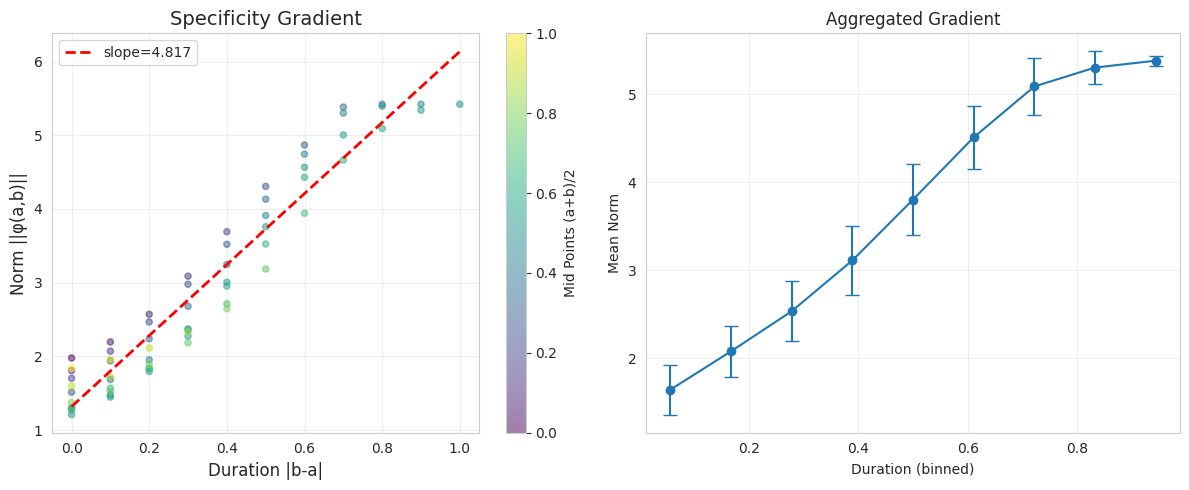


Correlation: 0.9625
Expected: Negative (longer → smaller norm)
Result: ✗ NEEDS TUNING



In [ ]:
test_specificity_gradient(model, 10)

In [ ]:
test_geodesic(model, a=0.1, b=0.9, c=0.3, d=0.7)

In [ ]:
def plot_all_intervals_with_geodesics(model, num_points=3, curvature=1.0):
    """
    Plot all intervals [i, j] where i <= j from equidistant grid points,
    along with geodesics connecting atomic intervals to their parent intervals.
    """
    model.eval()

    # Create grid of equidistant points in [0, 1]
    grid = np.linspace(0, 1, num_points + 1)

    # Generate all valid intervals [i, j] where i <= j
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]

    # Embed all intervals
    embeddings = {}
    with torch.no_grad():
        for i_idx, j_idx in intervals:
            i_val, j_val = grid[i_idx], grid[j_idx]
            interval = torch.tensor([[i_val, j_val]], dtype=torch.float32).to(device)
            emb = model(interval)
            if isinstance(emb, ManifoldTensor):
                emb = emb.tensor
            embeddings[(i_idx, j_idx)] = emb.squeeze(0).cpu().numpy()

    # Setup plot
    fig, ax = plt.subplots(figsize=(12, 12))

    # Draw Poincaré disk boundary
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)

    # Draw origin
    ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    # Draw geodesics: connect each non-atomic interval to its boundary atomic intervals
    for i_idx, j_idx in intervals:
        if i_idx < j_idx:  # Non-atomic interval
            z_interval = embeddings[(i_idx, j_idx)]
            z_left = embeddings[(i_idx, i_idx)]    # Left atomic endpoint
            z_right = embeddings[(j_idx, j_idx)]   # Right atomic endpoint

            # Geodesic from left atomic to right atomic (passing through interval)
            geodesic = compute_geodesic_points(z_left, z_right, curvature)
            ax.plot(geodesic[:, 0], geodesic[:, 1], 'b-', linewidth=1, alpha=0.3, zorder=1)

    # Draw all interval points
    for i_idx, j_idx in intervals:
        z = embeddings[(i_idx, j_idx)]
        i_val, j_val = grid[i_idx], grid[j_idx]

        if i_idx == j_idx:
            # Atomic interval [i, i]
            ax.scatter([z[0]], [z[1]], s=150, c='red', marker='o', edgecolors='black', linewidth=1.5, zorder=5)
            label = f'[{i_val:.2f}]'
        else:
            # Non-atomic interval [i, j]
            ax.scatter([z[0]], [z[1]], s=120, c='green', marker='s', edgecolors='black', linewidth=1.5, zorder=4)
            label = f'[{i_val:.2f},{j_val:.2f}]'

        # Attach label directly to point
        ax.annotate(label, (z[0], z[1]), textcoords="offset points", xytext=(5, 5), fontsize=8, zorder=11)

    # Formatting
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)
    ax.set_title(f'All Intervals & Geodesics (N={num_points})\nRed: atomic [i,i]  |  Green: non-atomic [i,j]', fontsize=14)

    plt.tight_layout()
    plt.show()

    return embeddings

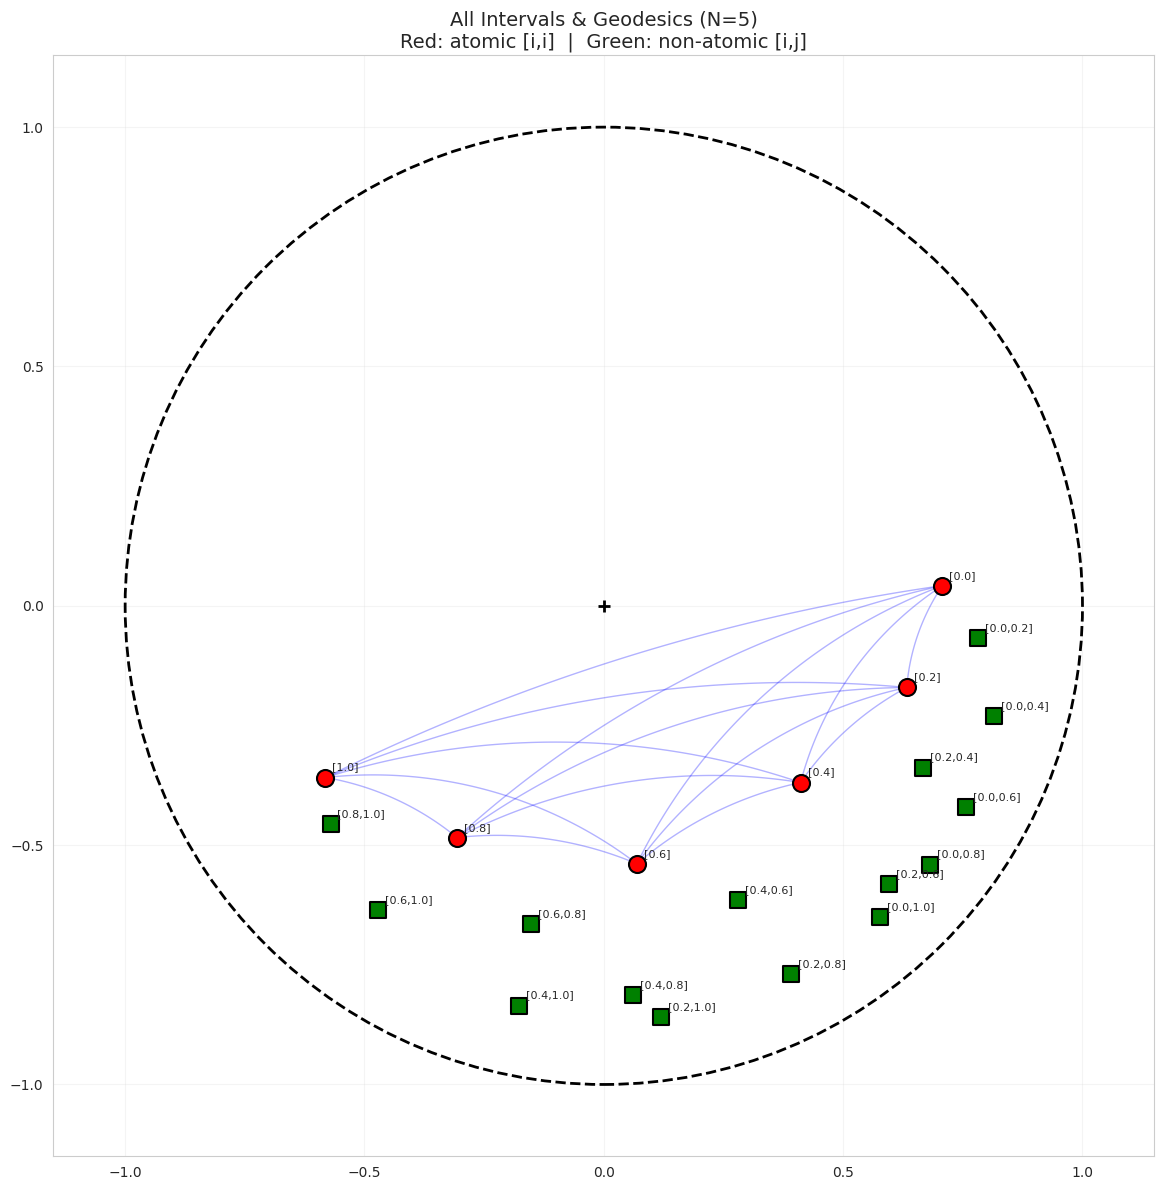

In [ ]:
embeddings = plot_all_intervals_with_geodesics(model, num_points=5)

In [ ]:
import imageio
from pathlib import Path

def train_model_with_gif(model, dataset, num_points=3, num_epochs=50, batch_size=32,
                          lr=0.0005, temperature=0.5, snapshot_every=1, curvature=1.0):
    """
    Train the hyperbolic interval encoder and capture snapshots for GIF.
    """
    from hypll.optim import RiemannianAdam

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    # Setup grid and intervals for visualization
    grid = np.linspace(0, 1, num_points + 1)
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]
    interval_tensors = torch.tensor([[grid[i], grid[j]] for i, j in intervals], dtype=torch.float32).to(device)

    # Storage for snapshots
    snapshots = []
    losses = []

    def capture_snapshot(epoch, loss):
        """Capture current embeddings."""
        model.eval()
        with torch.no_grad():
            emb = model(interval_tensors)
            if isinstance(emb, ManifoldTensor):
                emb = emb.tensor
            embeddings = emb.cpu().numpy()
        model.train()
        snapshots.append({
            'epoch': epoch,
            'loss': loss,
            'embeddings': embeddings.copy()
        })

    # Capture initial state
    capture_snapshot(0, float('inf'))

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for parent, positive, negatives in dataloader:
            parent = parent.to(device)
            positive = positive.to(device)
            negatives = negatives.to(device)

            parent_emb = model(parent)
            positive_emb = model(positive)

            bs, num_neg, _ = negatives.shape
            negatives_emb = model(negatives.view(-1, 2))

            if isinstance(negatives_emb, ManifoldTensor):
                neg_tensor = negatives_emb.tensor.view(bs, num_neg, -1)
                negatives_emb = ManifoldTensor(neg_tensor, manifold=model.manifold)
            else:
                negatives_emb = negatives_emb.view(bs, num_neg, -1)

            loss = info_nce_loss(parent_emb, positive_emb, negatives_emb,
                                 model.manifold, temperature=temperature)

            if torch.isnan(loss) or torch.isinf(loss):
                continue

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            scheduler.step()

            # Capture snapshot
            if (epoch + 1) % snapshot_every == 0:
                capture_snapshot(epoch + 1, avg_loss)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return losses, snapshots, grid, intervals


def create_training_gif(snapshots, grid, intervals, curvature=1.0,
                        output_path='training.gif', fps=5):
    """
    Create a GIF from training snapshots.
    """
    frames_dir = Path('gif_frames')
    frames_dir.mkdir(exist_ok=True)

    frame_paths = []

    for idx, snapshot in enumerate(snapshots):
        fig, ax = plt.subplots(figsize=(10, 10))

        embeddings = snapshot['embeddings']
        epoch = snapshot['epoch']
        loss = snapshot['loss']

        # Draw Poincaré disk boundary
        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

        # Draw geodesics between atomic endpoints
        for k, (i_idx, j_idx) in enumerate(intervals):
            if i_idx < j_idx:
                # Find indices of atomic endpoints
                left_k = intervals.index((i_idx, i_idx))
                right_k = intervals.index((j_idx, j_idx))
                z_left = embeddings[left_k]
                z_right = embeddings[right_k]

                geodesic = compute_geodesic_points(z_left, z_right, curvature)
                ax.plot(geodesic[:, 0], geodesic[:, 1], 'b-', linewidth=1, alpha=0.3, zorder=1)

        # Draw points
        for k, (i_idx, j_idx) in enumerate(intervals):
            z = embeddings[k]
            i_val, j_val = grid[i_idx], grid[j_idx]

            if i_idx == j_idx:
                ax.scatter([z[0]], [z[1]], s=150, c='red', marker='o',
                          edgecolors='black', linewidth=1.5, zorder=5)
                label = f'[{i_val:.2f}]'
            else:
                ax.scatter([z[0]], [z[1]], s=120, c='green', marker='s',
                          edgecolors='black', linewidth=1.5, zorder=4)
                label = f'[{i_val:.2f},{j_val:.2f}]'

            ax.annotate(label, (z[0], z[1]), textcoords="offset points",
                       xytext=(5, 5), fontsize=8, zorder=11)

        # Formatting
        ax.set_xlim(-1.15, 1.15)
        ax.set_ylim(-1.15, 1.15)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

        loss_str = f'{loss:.4f}' if loss != float('inf') else 'N/A'
        ax.set_title(f'Epoch {epoch}  |  Loss: {loss_str}\nRed: atomic [i,i]  |  Green: non-atomic [i,j]',
                    fontsize=14)

        # Save frame
        frame_path = frames_dir / f'frame_{idx:04d}.png'
        plt.tight_layout()
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close(fig)
        frame_paths.append(frame_path)

    # Create GIF
    images = [imageio.imread(fp) for fp in frame_paths]
    imageio.mimsave(output_path, images, fps=fps, loop=0)

    # Cleanup frames
    for fp in frame_paths:
        fp.unlink()
    frames_dir.rmdir()

    print(f"Saved GIF: {output_path}")
    return output_path




In [ ]:
# Usage

num_points = 10
dataset = IntervalDataset(num_samples=1000, num_negatives=5, num_points=10, endpoint_prob = 0)

model = HyperbolicIntervalEncoder(
    embedding_dim=2,
    c=1.0,
    euc_width=128,
    hyp_width=128
).to(device)

losses, snapshots, grid, intervals = train_model_with_gif(
    model, dataset,
    num_points=num_points,
    num_epochs=300,
    batch_size=32,
    lr=0.001,
    temperature=0.5,
    snapshot_every=2  # Capture every 2 epochs
)

create_training_gif(snapshots, grid, intervals, output_path='training.gif', fps=2)

Epoch 5/300, Loss: 0.3242
Epoch 10/300, Loss: 0.2158
Epoch 15/300, Loss: 0.1742
Epoch 20/300, Loss: 0.1508
Epoch 25/300, Loss: 0.1420
Epoch 30/300, Loss: 0.1378
Epoch 35/300, Loss: 0.1362
Epoch 40/300, Loss: 0.1249
Epoch 45/300, Loss: 0.1288
Epoch 50/300, Loss: 0.1319
Epoch 55/300, Loss: 0.1169
Epoch 60/300, Loss: 0.1141
Epoch 65/300, Loss: 0.1264
Epoch 70/300, Loss: 0.1109


KeyboardInterrupt: 

In [ ]:
np.linspace(0, 1, 4 + 1)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/tmp/ipython-input-892958688.py:65: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.linalg.norm(point - emb)
/tmp/ipython-input-892958688.py:97: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  intersection_dist = np.linalg.norm(apex - intersection_emb)


GEODESIC APEX CONJECTURE ANALYSIS

[0.00,0.00] <-> [0.00,0.20]
  Relationship: int2_contains_int1
  Intersection: [0.00,0.00]
  Distance apex -> intersection: 0.0214
  Nearest to apex: [0.00,0.40] (dist: 0.1393)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.00,0.00] <-> [0.00,0.40]
  Relationship: int2_contains_int1
  Intersection: [0.00,0.00]
  Distance apex -> intersection: 0.0749
  Nearest to apex: [0.00,0.20] (dist: 0.0267)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.00,0.00] <-> [0.00,0.60]
  Relationship: int2_contains_int1
  Intersection: [0.00,0.00]
  Distance apex -> intersection: 0.1681
  Nearest to apex: [0.00,0.40] (dist: 0.0810)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.00,0.00] <-> [0.00,0.80]
  Relationship: int2_contains_int1
  Intersection: [0.00,0.00]
  Distance apex -> intersection: 0.4048
  Nearest to apex: [0.20,0.20] (dist: 0.0707)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.00,0.00] <-> [0.00,1.00]
  Relationship: i

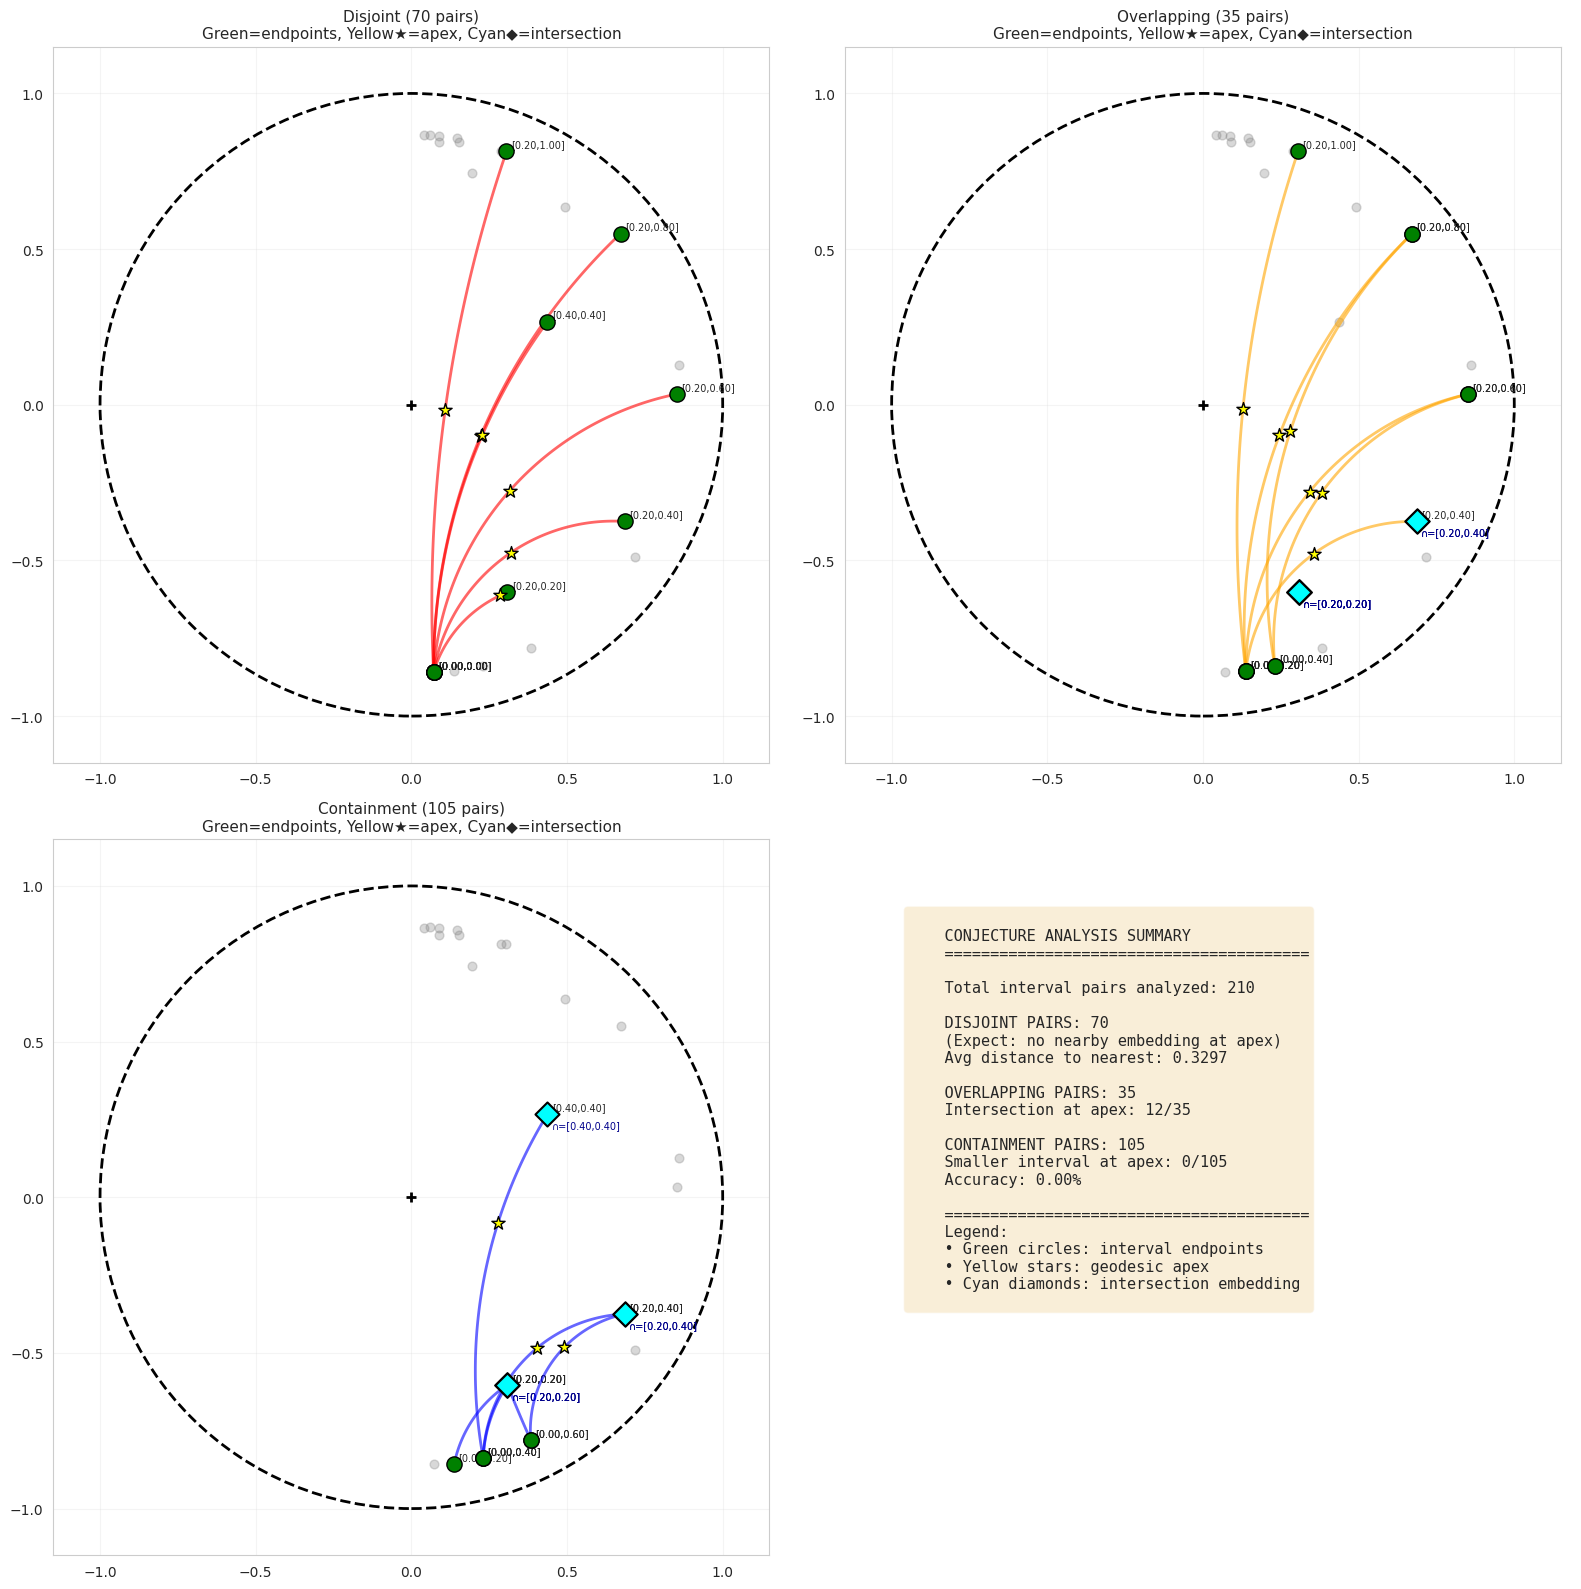


DETAILED PAIR EXAMINATIONS

>>> CONTAINMENT EXAMPLE:


/tmp/ipython-input-892958688.py:358: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists_to_int = np.linalg.norm(geodesic - z_int, axis=1)
/tmp/ipython-input-892958688.py:370: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(geodesic - emb, axis=1)


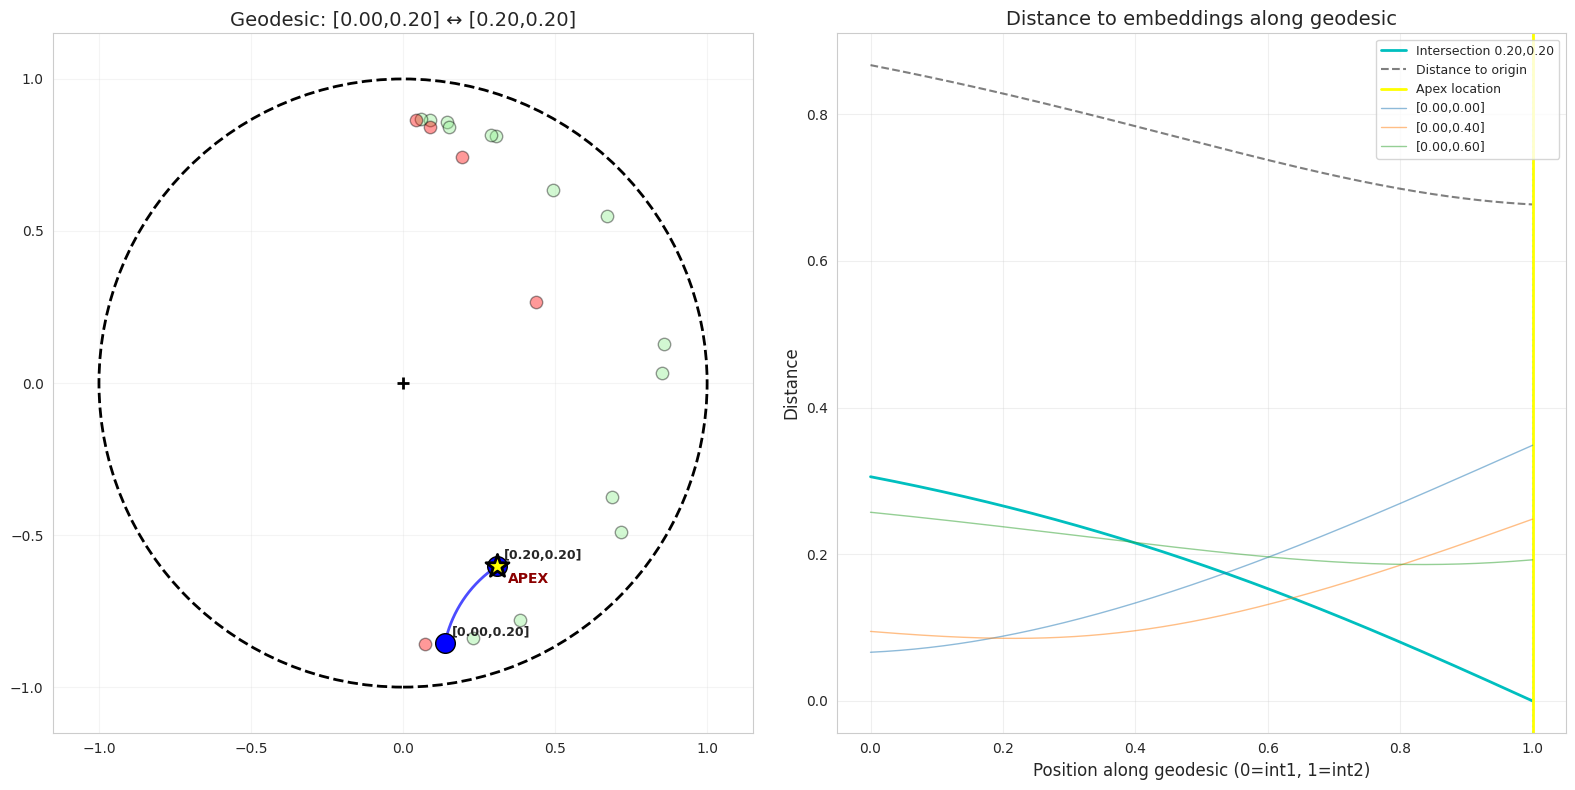


Detailed Analysis: [0.00,0.20] ↔ [0.20,0.20]
--------------------------------------------------
Intersection: ∩=[0.20,0.20]
Distance from apex to intersection embedding: 0.0000
Nearest embedding to apex: [0.00,0.60] (dist: 0.1925)

>>> OVERLAP EXAMPLE:


/tmp/ipython-input-892958688.py:394: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist_to_apex = np.linalg.norm(apex - embeddings[intersection])
/tmp/ipython-input-892958688.py:405: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.linalg.norm(apex - emb)


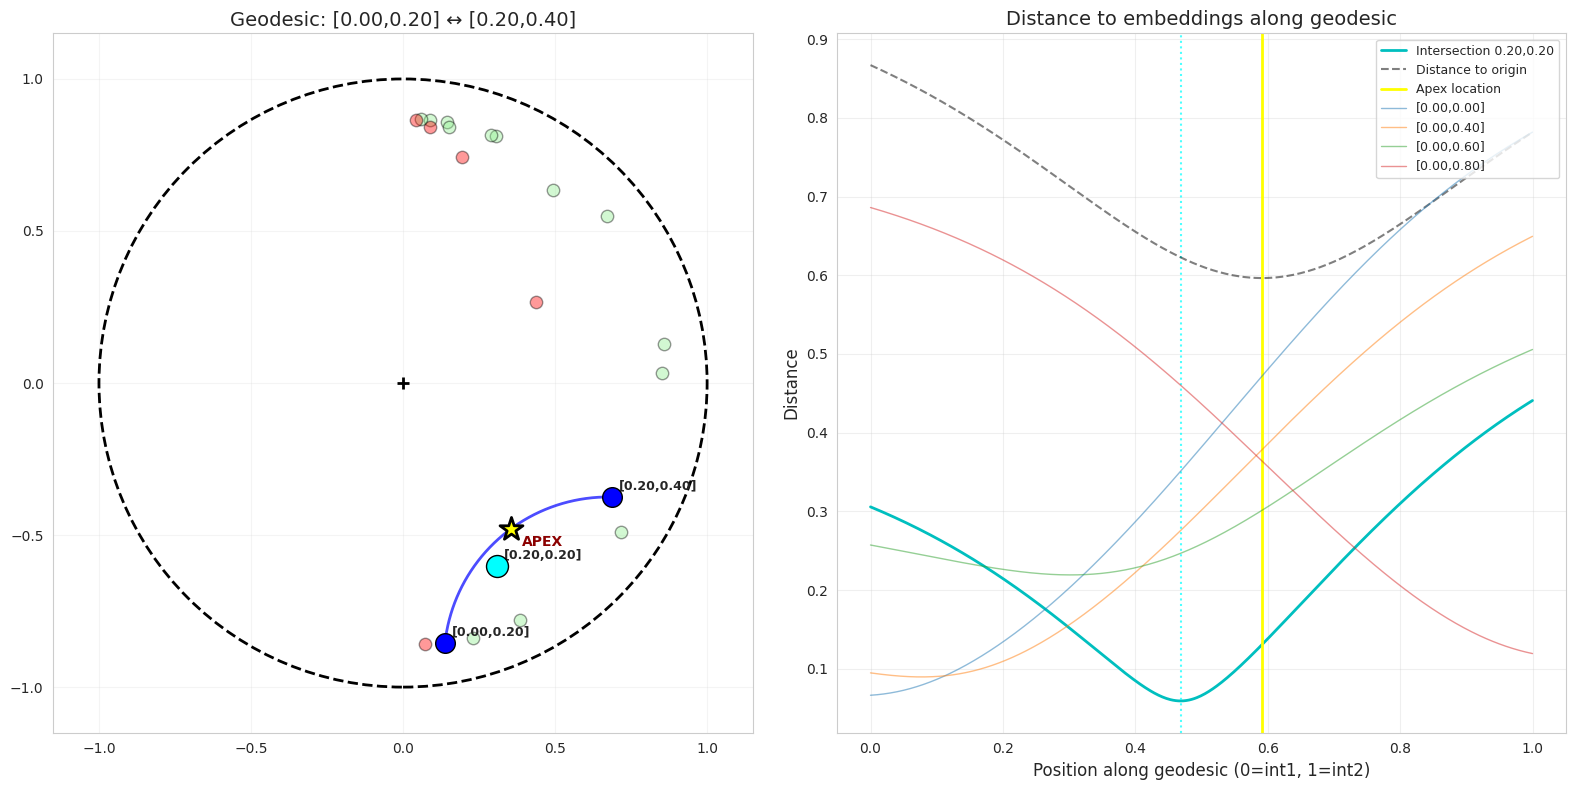


Detailed Analysis: [0.00,0.20] ↔ [0.20,0.40]
--------------------------------------------------
Intersection: ∩=[0.20,0.20]
Distance from apex to intersection embedding: 0.1305
Nearest embedding to apex: [0.20,0.20] (dist: 0.1305)

>>> DISJOINT EXAMPLE:


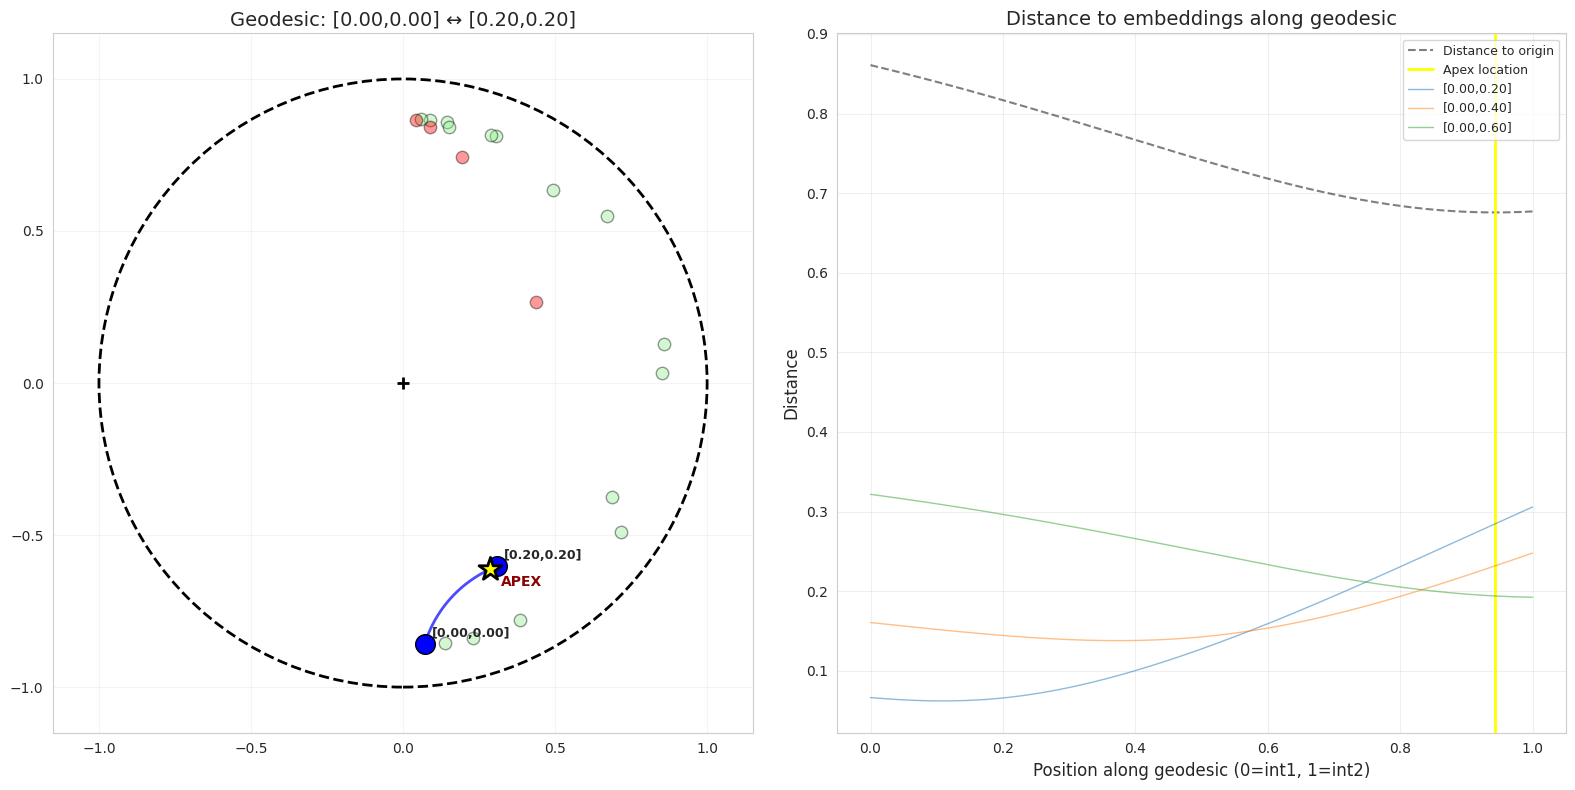


Detailed Analysis: [0.00,0.00] ↔ [0.20,0.20]
--------------------------------------------------
Intersection: EMPTY
Nearest embedding to apex: [0.00,0.60] (dist: 0.1940)


In [ ]:
def analyze_geodesic_apex_conjecture(model, num_points=3, curvature=1.0):
    """
    Visualize and test the geodesic apex conjecture:
    - Apex of geodesic between two intervals should correspond to their intersection
    - If intersection is empty, no embedding nearby
    - If one contains the other, the smaller one is at the apex
    """
    model.eval()

    # Create grid and intervals
    grid = np.linspace(0, 1, num_points + 1)
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]

    # Embed all intervals
    embeddings = {}
    with torch.no_grad():
        for i_idx, j_idx in intervals:
            i_val, j_val = grid[i_idx], grid[j_idx]
            interval = torch.tensor([[i_val, j_val]], dtype=torch.float32).to(device)
            emb = model(interval)
            if isinstance(emb, ManifoldTensor):
                emb = emb.tensor
            embeddings[(i_idx, j_idx)] = emb.squeeze(0).cpu().numpy()

    # Helper functions
    def interval_intersection(int1, int2):
        """Compute intersection of two intervals. Returns None if empty."""
        i1, j1 = int1
        i2, j2 = int2
        i_int = max(i1, i2)
        j_int = min(j1, j2)
        if i_int <= j_int:
            return (i_int, j_int)
        return None

    def interval_relationship(int1, int2):
        """Classify relationship: 'disjoint', 'overlap', 'int1_contains_int2', 'int2_contains_int1', 'equal'."""
        i1, j1 = int1
        i2, j2 = int2

        if int1 == int2:
            return 'equal'
        if j1 < i2 or j2 < i1:
            return 'disjoint'
        if i1 <= i2 and j2 <= j1:
            return 'int1_contains_int2'
        if i2 <= i1 and j1 <= j2:
            return 'int2_contains_int1'
        return 'overlap'

    def find_geodesic_apex(z1, z2, curvature):
        """Find the apex (closest point to origin) on the geodesic between z1 and z2."""
        geodesic = compute_geodesic_points(z1, z2, curvature, num_points=200)
        norms = np.linalg.norm(geodesic, axis=1)
        apex_idx = np.argmin(norms)
        return geodesic[apex_idx], norms[apex_idx]

    def find_nearest_embedding(point, embeddings, exclude=None):
        """Find nearest embedding to a point."""
        min_dist = float('inf')
        nearest_key = None
        for key, emb in embeddings.items():
            if exclude and key in exclude:
                continue
            dist = np.linalg.norm(point - emb)
            if dist < min_dist:
                min_dist = dist
                nearest_key = key
        return nearest_key, min_dist

    # Analyze all pairs
    results = []
    interval_list = list(intervals)

    for idx1, int1 in enumerate(interval_list):
        for idx2, int2 in enumerate(interval_list):
            if idx2 <= idx1:
                continue

            z1 = embeddings[int1]
            z2 = embeddings[int2]

            # Compute apex
            apex, apex_norm = find_geodesic_apex(z1, z2, curvature)

            # Compute intersection
            intersection = interval_intersection(int1, int2)
            relationship = interval_relationship(int1, int2)

            # Find nearest embedding to apex
            nearest_key, nearest_dist = find_nearest_embedding(apex, embeddings, exclude={int1, int2})

            # If intersection exists, check distance to intersection embedding
            intersection_dist = None
            if intersection and intersection in embeddings:
                intersection_emb = embeddings[intersection]
                intersection_dist = np.linalg.norm(apex - intersection_emb)

            results.append({
                'int1': int1,
                'int2': int2,
                'relationship': relationship,
                'intersection': intersection,
                'apex': apex,
                'apex_norm': apex_norm,
                'nearest_to_apex': nearest_key,
                'nearest_dist': nearest_dist,
                'intersection_dist': intersection_dist
            })

    # Print analysis
    print("=" * 80)
    print("GEODESIC APEX CONJECTURE ANALYSIS")
    print("=" * 80)

    for r in results:
        int1_str = f"[{grid[r['int1'][0]]:.2f},{grid[r['int1'][1]]:.2f}]"
        int2_str = f"[{grid[r['int2'][0]]:.2f},{grid[r['int2'][1]]:.2f}]"

        print(f"\n{int1_str} <-> {int2_str}")
        print(f"  Relationship: {r['relationship']}")

        if r['intersection']:
            int_str = f"[{grid[r['intersection'][0]]:.2f},{grid[r['intersection'][1]]:.2f}]"
            print(f"  Intersection: {int_str}")
            if r['intersection_dist'] is not None:
                print(f"  Distance apex -> intersection: {r['intersection_dist']:.4f}")
        else:
            print(f"  Intersection: EMPTY")

        nearest_str = f"[{grid[r['nearest_to_apex'][0]]:.2f},{grid[r['nearest_to_apex'][1]]:.2f}]"
        print(f"  Nearest to apex: {nearest_str} (dist: {r['nearest_dist']:.4f})")

        # Check conjecture
        if r['relationship'] in ['int1_contains_int2', 'int2_contains_int1']:
            smaller = r['int2'] if r['relationship'] == 'int1_contains_int2' else r['int1']
            if r['nearest_to_apex'] == smaller:
                print(f"  ✓ INCLUSION: Smaller interval is nearest to apex")
            else:
                print(f"  ✗ INCLUSION: Smaller interval NOT nearest to apex")
        elif r['intersection']:
            if r['nearest_to_apex'] == r['intersection']:
                print(f"  ✓ OVERLAP: Intersection is nearest to apex")
            else:
                print(f"  ? OVERLAP: Intersection not nearest (nearest: {nearest_str})")

    return results, embeddings, grid, intervals


def visualize_apex_conjecture(results, embeddings, grid, intervals, curvature=1.0):
    """
    Create visualization showing geodesics, apexes, and intersections.
    """
    # Filter to interesting cases (exclude equal, keep a subset)
    interesting = [r for r in results if r['relationship'] != 'equal']

    # Create subplots for different relationship types
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()

    categories = {
        'disjoint': ('Disjoint Intervals', 'red'),
        'overlap': ('Overlapping Intervals', 'orange'),
        'int1_contains_int2': ('Containment (→)', 'blue'),
        'int2_contains_int1': ('Containment (←)', 'blue')
    }

    # Group results by category
    grouped = {k: [] for k in categories}
    for r in interesting:
        grouped[r['relationship']].append(r)

    # Combine containment cases
    containment = grouped['int1_contains_int2'] + grouped['int2_contains_int1']
    plot_groups = [
        ('Disjoint', grouped['disjoint'], 'red'),
        ('Overlapping', grouped['overlap'], 'orange'),
        ('Containment', containment, 'blue'),
    ]

    for ax_idx, (title, group, color) in enumerate(plot_groups):
        ax = axes[ax_idx]

        # Draw Poincaré disk
        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.scatter([0], [0], s=60, c='black', marker='+', linewidth=2, zorder=10)

        # Draw all embeddings faintly
        for key, emb in embeddings.items():
            ax.scatter([emb[0]], [emb[1]], s=40, c='gray', alpha=0.3, zorder=2)

        # Draw cases in this group
        for r in group[:6]:  # Limit to 6 examples per category
            z1 = embeddings[r['int1']]
            z2 = embeddings[r['int2']]
            apex = r['apex']

            # Draw geodesic
            geodesic = compute_geodesic_points(z1, z2, curvature)
            ax.plot(geodesic[:, 0], geodesic[:, 1], '-', color=color, linewidth=2, alpha=0.6, zorder=3)

            # Draw endpoints
            int1_str = f"[{grid[r['int1'][0]]:.2f},{grid[r['int1'][1]]:.2f}]"
            int2_str = f"[{grid[r['int2'][0]]:.2f},{grid[r['int2'][1]]:.2f}]"

            ax.scatter([z1[0]], [z1[1]], s=120, c='green', marker='o', edgecolors='black', zorder=5)
            ax.scatter([z2[0]], [z2[1]], s=120, c='green', marker='o', edgecolors='black', zorder=5)
            ax.annotate(int1_str, (z1[0], z1[1]), fontsize=7, xytext=(3, 3), textcoords='offset points')
            ax.annotate(int2_str, (z2[0], z2[1]), fontsize=7, xytext=(3, 3), textcoords='offset points')

            # Draw apex
            ax.scatter([apex[0]], [apex[1]], s=100, c='yellow', marker='*', edgecolors='black', linewidth=1, zorder=6)

            # Draw intersection embedding if exists
            if r['intersection'] and r['intersection'] in embeddings:
                z_int = embeddings[r['intersection']]
                ax.scatter([z_int[0]], [z_int[1]], s=150, c='cyan', marker='D', edgecolors='black', linewidth=1.5, zorder=7)
                i_val = grid[r['intersection'][0]]
                j_val = grid[r['intersection'][1]]
                int_str = f"∩=[{i_val:.2f},{j_val:.2f}]"
                ax.annotate(int_str, (z_int[0], z_int[1]), fontsize=7, xytext=(3, -10), textcoords='offset points', color='darkblue')

        ax.set_xlim(-1.15, 1.15)
        ax.set_ylim(-1.15, 1.15)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)
        ax.set_title(f'{title} ({len(group)} pairs)\nGreen=endpoints, Yellow★=apex, Cyan◆=intersection', fontsize=11)

    # Summary statistics in 4th subplot
    ax = axes[3]
    ax.axis('off')

    # Compute statistics
    containment_correct = sum(1 for r in containment
                              if r['nearest_to_apex'] == (r['int2'] if r['relationship'] == 'int1_contains_int2' else r['int1']))
    overlap_with_int = [r for r in grouped['overlap'] if r['intersection']]
    overlap_correct = sum(1 for r in overlap_with_int if r['nearest_to_apex'] == r['intersection'])

    stats_text = f"""
    CONJECTURE ANALYSIS SUMMARY
    {'='*40}

    Total interval pairs analyzed: {len(interesting)}

    DISJOINT PAIRS: {len(grouped['disjoint'])}
    (Expect: no nearby embedding at apex)
    Avg distance to nearest: {np.mean([r['nearest_dist'] for r in grouped['disjoint']]):.4f}

    OVERLAPPING PAIRS: {len(grouped['overlap'])}
    Intersection at apex: {overlap_correct}/{len(overlap_with_int)}

    CONTAINMENT PAIRS: {len(containment)}
    Smaller interval at apex: {containment_correct}/{len(containment)}
    Accuracy: {100*containment_correct/len(containment) if containment else 0:.2f}%

    {'='*40}
    Legend:
    • Green circles: interval endpoints
    • Yellow stars: geodesic apex
    • Cyan diamonds: intersection embedding
    """

    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('apex_conjecture.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig


def detailed_pair_visualization(model, embeddings, grid, int1, int2, curvature=1.0):
    """
    Detailed visualization of a single pair to examine the conjecture closely.
    """
    model.eval()

    z1 = embeddings[int1]
    z2 = embeddings[int2]

    # Compute geodesic with many points
    geodesic = compute_geodesic_points(z1, z2, curvature, num_points=500)
    norms = np.linalg.norm(geodesic, axis=1)
    apex_idx = np.argmin(norms)
    apex = geodesic[apex_idx]

    # Compute intersection
    i_int = max(int1[0], int2[0])
    j_int = min(int1[1], int2[1])
    intersection = (i_int, j_int) if i_int <= j_int else None

    # Setup figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Left: Poincaré disk view
    ax = axes[0]
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    # Draw all embeddings
    for key, emb in embeddings.items():
        i_val, j_val = grid[key[0]], grid[key[1]]
        is_atomic = key[0] == key[1]
        color = 'red' if is_atomic else 'lightgreen'
        alpha = 0.4

        # Highlight relevant intervals
        if key == int1 or key == int2:
            color = 'blue'
            alpha = 1.0
            size = 200
        elif key == intersection:
            color = 'cyan'
            alpha = 1.0
            size = 250
        else:
            size = 80

        ax.scatter([emb[0]], [emb[1]], s=size, c=color, alpha=alpha,
                   edgecolors='black', linewidth=1, zorder=5 if alpha == 1 else 2)

        if key in [int1, int2, intersection]:
            label = f"[{i_val:.2f},{j_val:.2f}]"
            ax.annotate(label, (emb[0], emb[1]), fontsize=9, fontweight='bold',
                       xytext=(5, 5), textcoords='offset points')

    # Draw geodesic
    ax.plot(geodesic[:, 0], geodesic[:, 1], 'b-', linewidth=2, alpha=0.7, zorder=3)

    # Draw apex
    ax.scatter([apex[0]], [apex[1]], s=300, c='yellow', marker='*',
               edgecolors='black', linewidth=2, zorder=8)
    ax.annotate('APEX', (apex[0], apex[1]), fontsize=10, fontweight='bold',
               xytext=(8, -12), textcoords='offset points', color='darkred')

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)

    int1_str = f"[{grid[int1[0]]:.2f},{grid[int1[1]]:.2f}]"
    int2_str = f"[{grid[int2[0]]:.2f},{grid[int2[1]]:.2f}]"
    ax.set_title(f'Geodesic: {int1_str} ↔ {int2_str}', fontsize=14)

    # Right: Distance along geodesic to each embedding
    ax = axes[1]

    # For each point on geodesic, compute distance to key embeddings
    t_vals = np.linspace(0, 1, len(geodesic))

    # Distance to intersection (if exists)
    if intersection and intersection in embeddings:
        z_int = embeddings[intersection]
        dists_to_int = np.linalg.norm(geodesic - z_int, axis=1)
        ax.plot(t_vals, dists_to_int, 'c-', linewidth=2, label=f'Intersection {grid[intersection[0]]:.2f},{grid[intersection[1]]:.2f}')
        ax.axvline(t_vals[np.argmin(dists_to_int)], color='cyan', linestyle=':', alpha=0.7)

    # Distance to origin (for apex reference)
    ax.plot(t_vals, norms, 'k--', linewidth=1.5, alpha=0.5, label='Distance to origin')
    ax.axvline(t_vals[apex_idx], color='yellow', linewidth=2, label='Apex location')

    # Distance to other nearby embeddings
    for key, emb in embeddings.items():
        if key in [int1, int2, intersection]:
            continue
        dists = np.linalg.norm(geodesic - emb, axis=1)
        min_dist = np.min(dists)
        if min_dist < 0.3:  # Only show if close
            label = f"[{grid[key[0]]:.2f},{grid[key[1]]:.2f}]"
            ax.plot(t_vals, dists, '-', linewidth=1, alpha=0.5, label=label)

    ax.set_xlabel('Position along geodesic (0=int1, 1=int2)', fontsize=12)
    ax.set_ylabel('Distance', fontsize=12)
    ax.set_title('Distance to embeddings along geodesic', fontsize=14)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"\nDetailed Analysis: {int1_str} ↔ {int2_str}")
    print("-" * 50)
    if intersection:
        i_val = grid[r['intersection'][0]]
        j_val = grid[r['intersection'][1]]
        int_str = f"∩=[{i_val:.2f},{j_val:.2f}]"
        print(f"Intersection: {int_str}")
        if intersection in embeddings:
            dist_to_apex = np.linalg.norm(apex - embeddings[intersection])
            print(f"Distance from apex to intersection embedding: {dist_to_apex:.4f}")
    else:
        print("Intersection: EMPTY")

    # Find nearest embedding to apex
    min_dist = float('inf')
    nearest = None
    for key, emb in embeddings.items():
        if key in [int1, int2]:
            continue
        dist = np.linalg.norm(apex - emb)
        if dist < min_dist:
            min_dist = dist
            nearest = key

    if nearest:
        nearest_str = f"[{grid[nearest[0]]:.2f},{grid[nearest[1]]:.2f}]"
        print(f"Nearest embedding to apex: {nearest_str} (dist: {min_dist:.4f})")


# Run the analysis
results, embeddings, grid, intervals = analyze_geodesic_apex_conjecture(model, num_points=5)
visualize_apex_conjecture(results, embeddings, grid, intervals)

# Examine specific interesting pairs
print("\n" + "="*80)
print("DETAILED PAIR EXAMINATIONS")
print("="*80)

# Find examples of each type
for r in results:
    if r['relationship'] == 'int1_contains_int2':
        print("\n>>> CONTAINMENT EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'])
        break

for r in results:
    if r['relationship'] == 'overlap':
        print("\n>>> OVERLAP EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'])
        break

for r in results:
    if r['relationship'] == 'disjoint':
        print("\n>>> DISJOINT EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'])
        break

GEODESIC APEX CONJECTURE ANALYSIS (Hyperbolic Distances)

[0.0,0.0] <-> [0.0,0.2]
  Relationship: int2_contains_int1
  Intersection: [0.0,0.0]
  Hyperbolic distance apex -> intersection: 0.0671
  Nearest to apex (hyperbolic): [0.0,0.0] (dist: 0.0671)
  ✓ INCLUSION: Smaller interval is nearest to apex

[0.0,0.0] <-> [0.0,0.4]
  Relationship: int2_contains_int1
  Intersection: [0.0,0.0]
  Hyperbolic distance apex -> intersection: 0.6427
  Nearest to apex (hyperbolic): [0.0,0.2] (dist: 0.5156)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.0,0.0] <-> [0.0,0.6]
  Relationship: int2_contains_int1
  Intersection: [0.0,0.0]
  Hyperbolic distance apex -> intersection: 0.9387
  Nearest to apex (hyperbolic): [0.2,0.2] (dist: 0.4697)
  ✗ INCLUSION: Smaller interval NOT nearest to apex

[0.0,0.0] <-> [0.0,0.8]
  Relationship: int2_contains_int1
  Intersection: [0.0,0.0]
  Hyperbolic distance apex -> intersection: 1.1108
  Nearest to apex (hyperbolic): [0.2,0.2] (dist: 0.4201)
  ✗ INCLUSIO

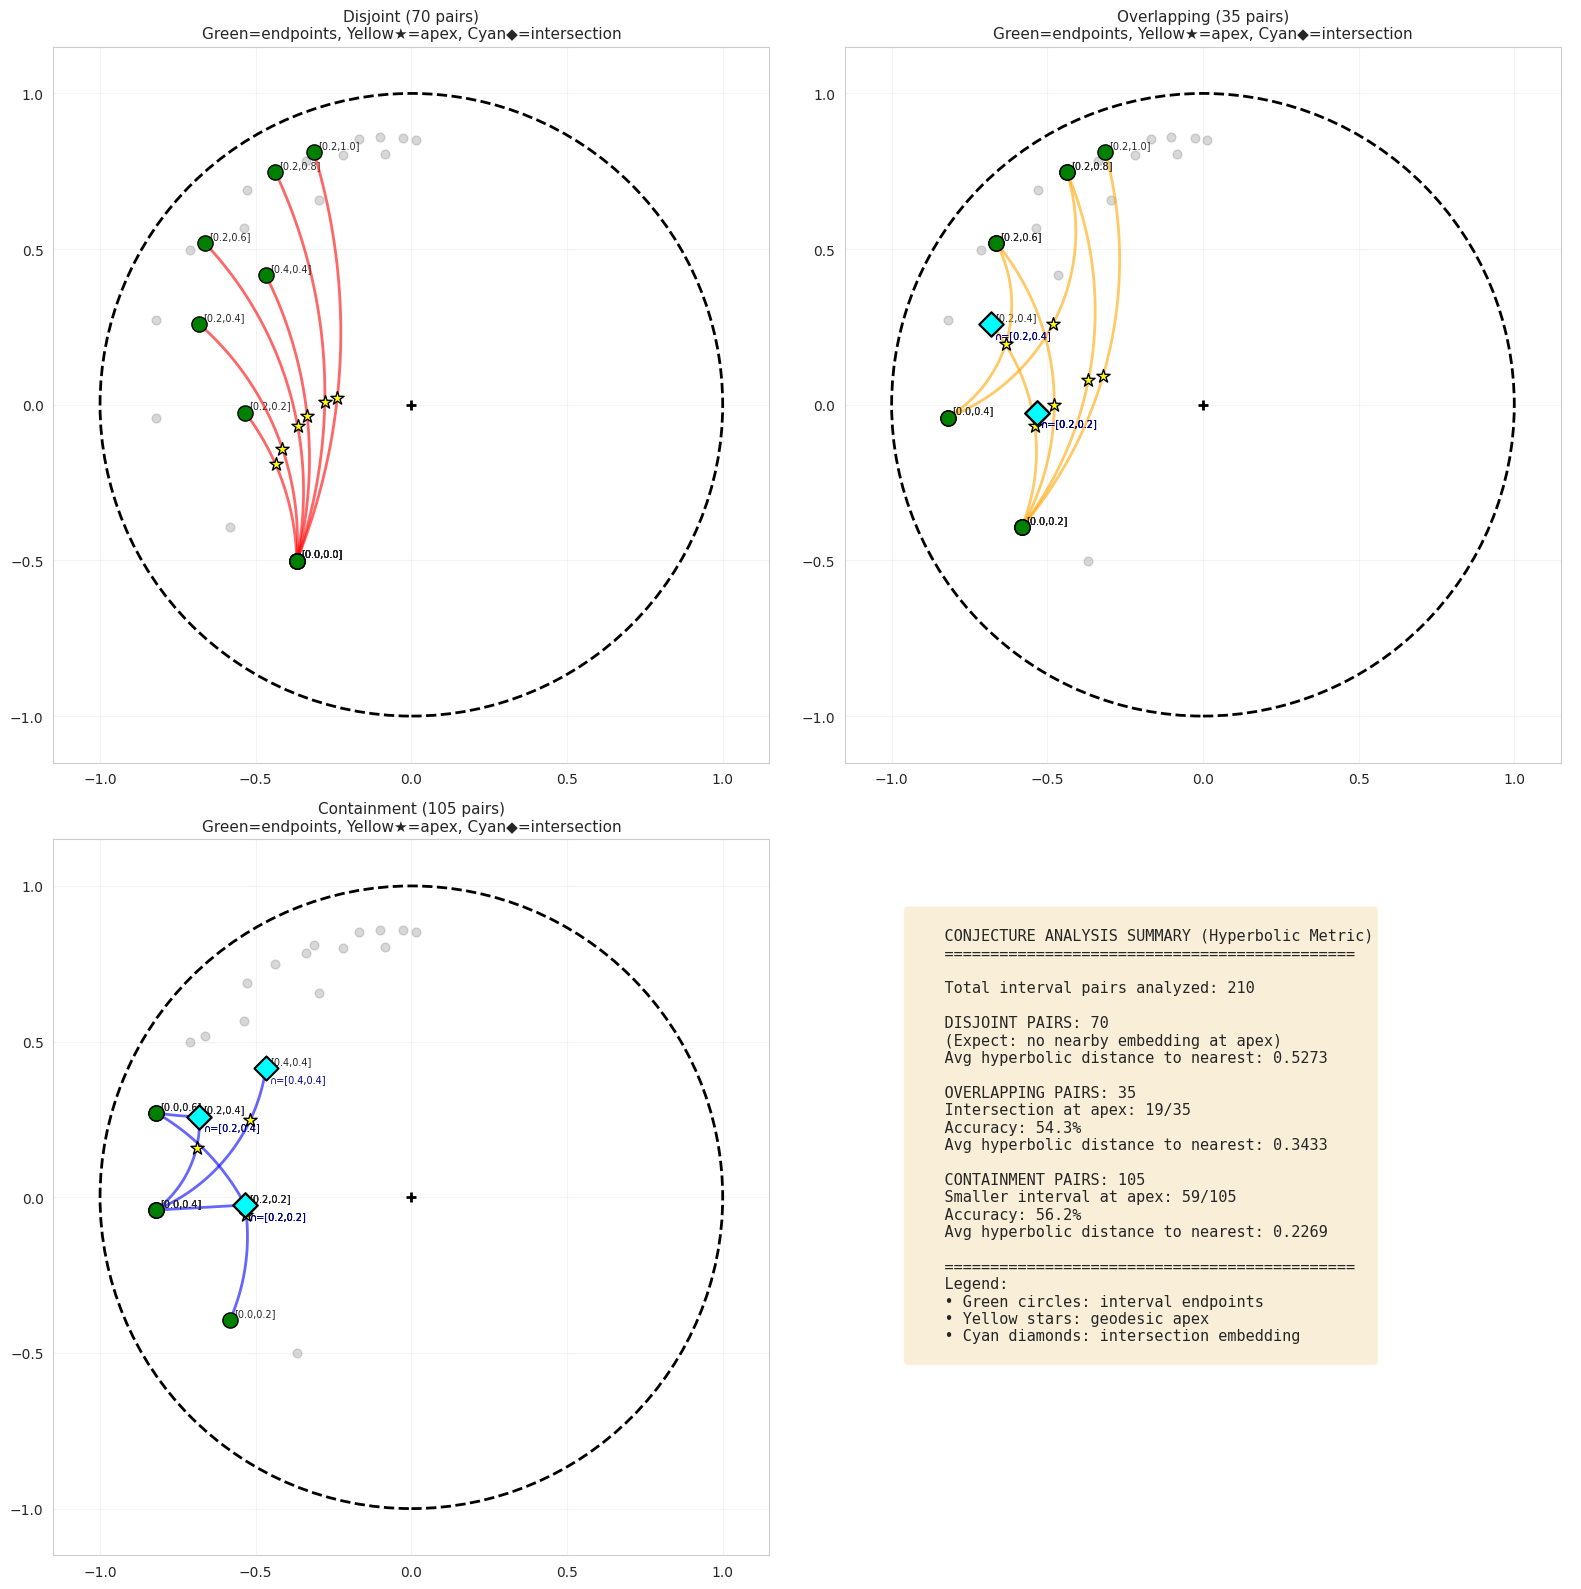


DETAILED PAIR EXAMINATIONS

>>> CONTAINMENT EXAMPLE:


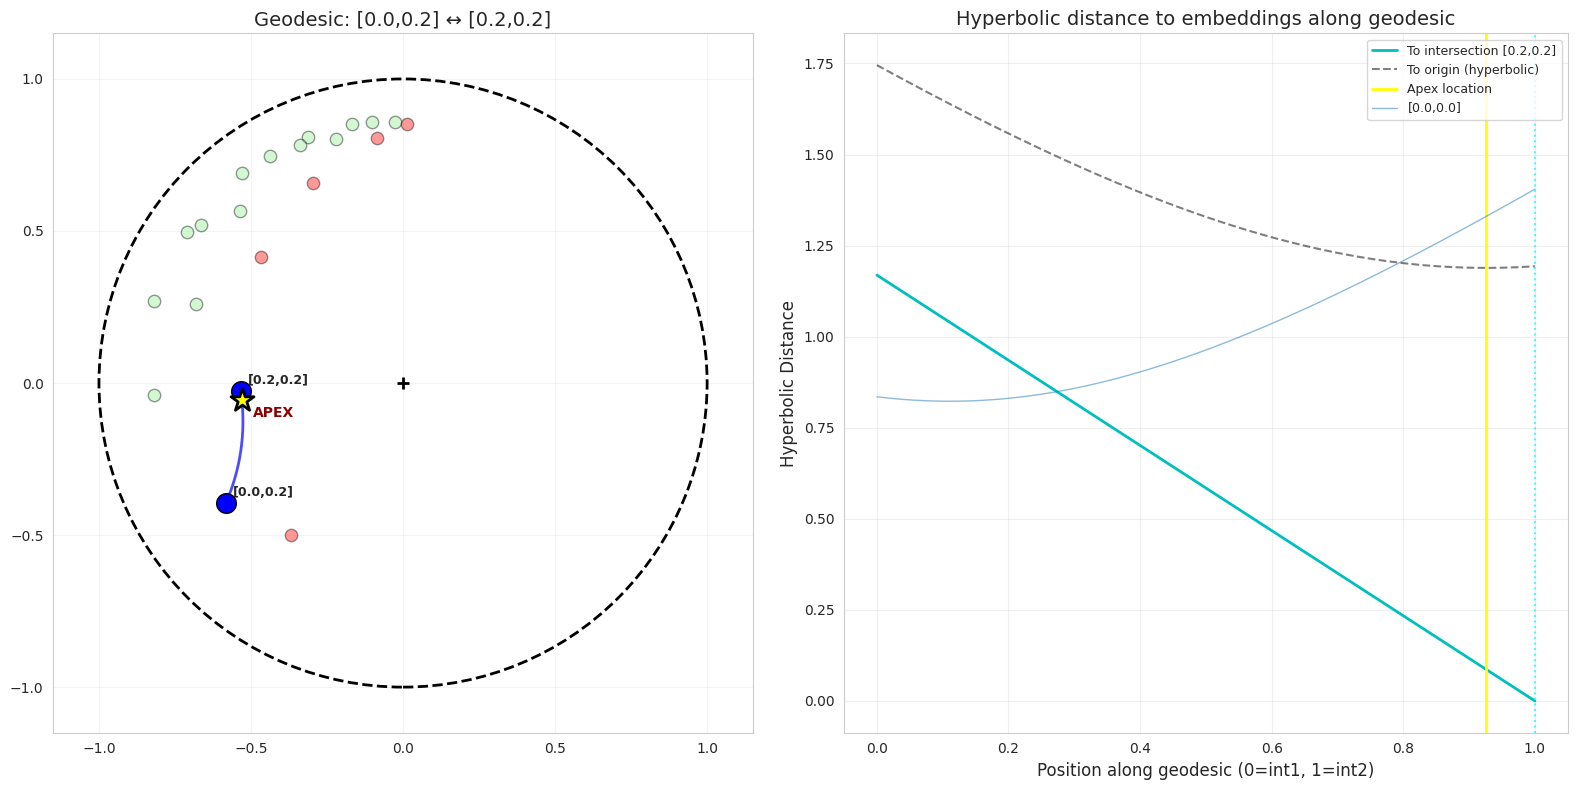


Detailed Analysis: [0.0,0.2] ↔ [0.2,0.2]
--------------------------------------------------
Intersection: [0.2,0.2]
Hyperbolic distance from apex to intersection embedding: 0.0867
Nearest embedding to apex (hyperbolic): [0.0,0.4] (dist: 1.1402)

>>> OVERLAP EXAMPLE:


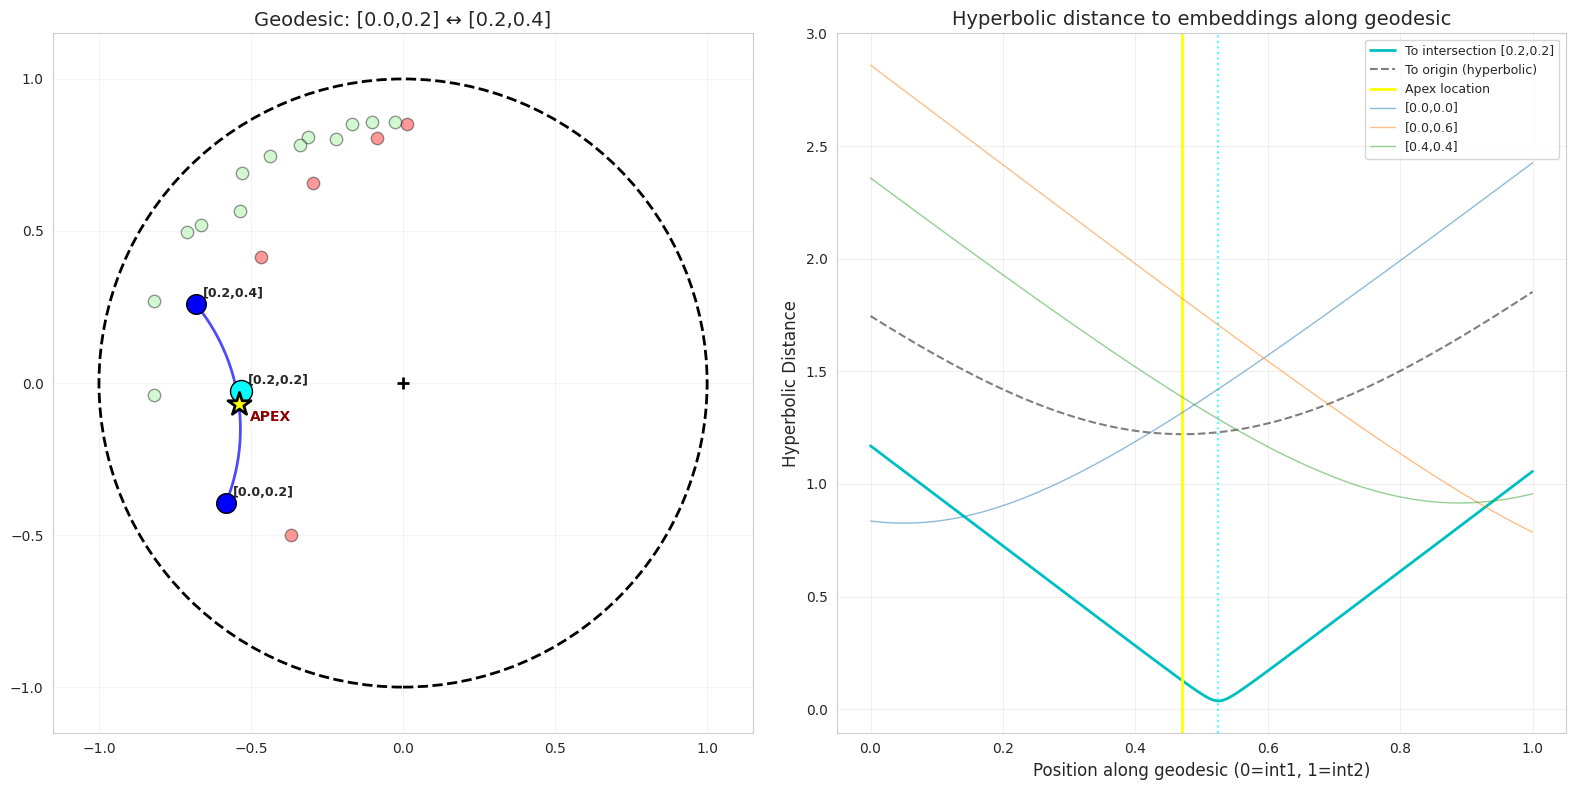


Detailed Analysis: [0.0,0.2] ↔ [0.2,0.4]
--------------------------------------------------
Intersection: [0.2,0.2]
Hyperbolic distance from apex to intersection embedding: 0.1268
Nearest embedding to apex (hyperbolic): [0.2,0.2] (dist: 0.1268)

>>> DISJOINT EXAMPLE:


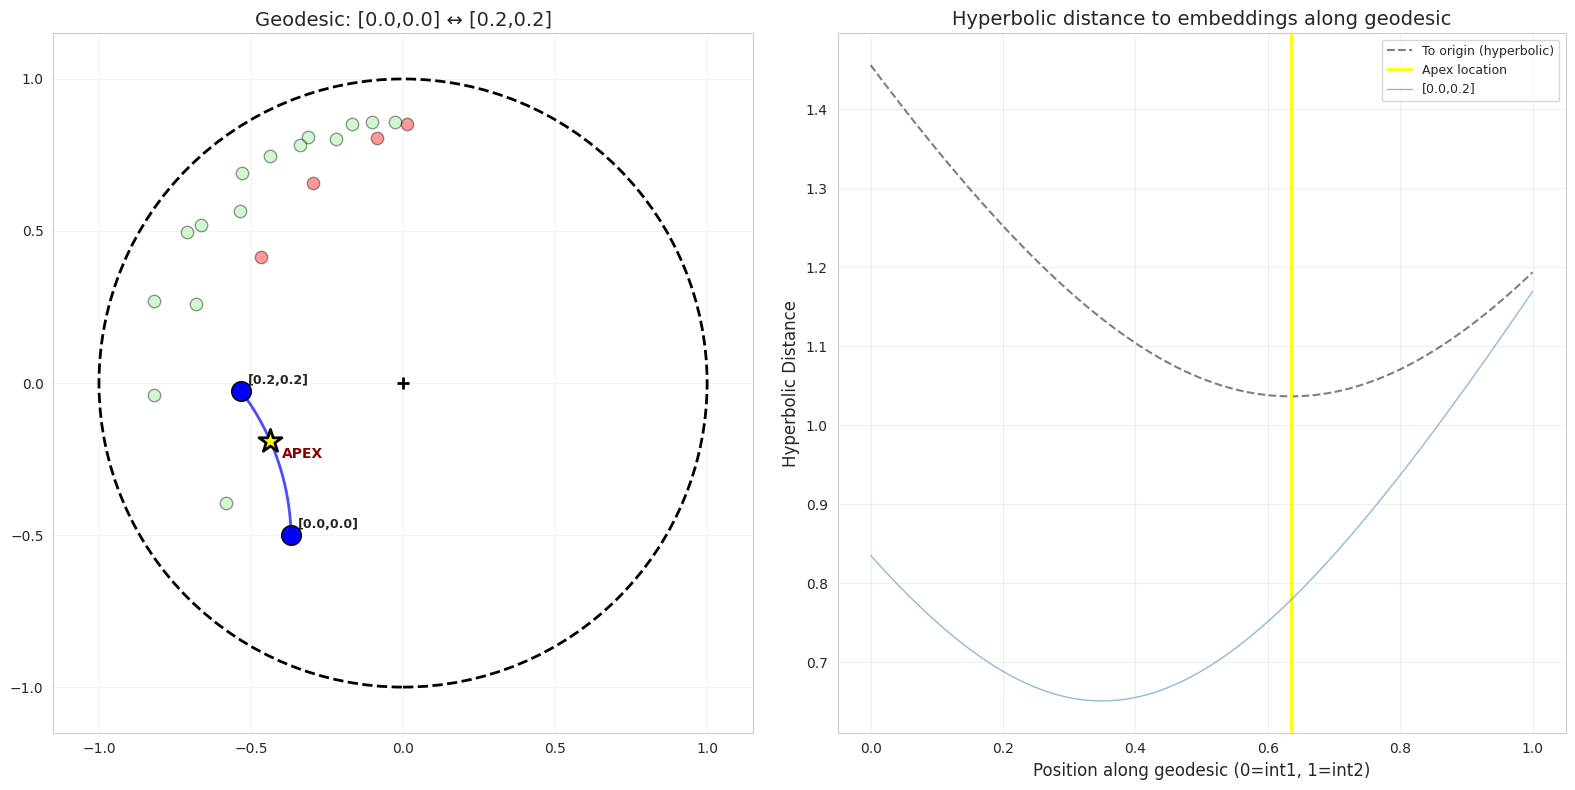


Detailed Analysis: [0.0,0.0] ↔ [0.2,0.2]
--------------------------------------------------
Intersection: EMPTY
Nearest embedding to apex (hyperbolic): [0.0,0.2] (dist: 0.7788)


In [ ]:
def hyperbolic_distance(u, v, curvature=1.0):
    """
    Compute hyperbolic distance between two points in the Poincaré disk.

    d(u, v) = (1/√K) * arcosh(1 + 2K * ||u - v||² / ((1 - K||u||²)(1 - K||v||²)))
    """
    K = curvature
    u = np.atleast_1d(u)
    v = np.atleast_1d(v)

    diff_norm_sq = np.sum((u - v) ** 2, axis=-1)
    u_norm_sq = np.sum(u ** 2, axis=-1)
    v_norm_sq = np.sum(v ** 2, axis=-1)

    # Clamp norms to avoid numerical issues at boundary
    u_norm_sq = np.clip(u_norm_sq, 0, 1 - 1e-10)
    v_norm_sq = np.clip(v_norm_sq, 0, 1 - 1e-10)

    numerator = 2 * K * diff_norm_sq
    denominator = (1 - K * u_norm_sq) * (1 - K * v_norm_sq)

    # arcosh(x) = log(x + sqrt(x^2 - 1)), need x >= 1
    arg = 1 + numerator / denominator
    arg = np.maximum(arg, 1.0)  # Numerical safety

    dist = (1 / np.sqrt(K)) * np.arccosh(arg)
    return dist


def hyperbolic_distance_to_origin(z, curvature=1.0):
    """
    Compute hyperbolic distance from origin to point z in the Poincaré disk.

    d(0, z) = (2/√K) * arctanh(√K * ||z||)
    """
    K = curvature
    z = np.atleast_1d(z)
    z_norm = np.linalg.norm(z, axis=-1)

    # Clamp to avoid numerical issues
    z_norm = np.clip(z_norm, 0, (1 / np.sqrt(K)) - 1e-10)

    dist = (2 / np.sqrt(K)) * np.arctanh(np.sqrt(K) * z_norm)
    return dist


def analyze_geodesic_apex_conjecture(model, num_points=3, curvature=1.0):
    """
    Visualize and test the geodesic apex conjecture using hyperbolic distances.
    """
    model.eval()

    # Create grid and intervals
    grid = np.linspace(0, 1, num_points + 1)
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]

    # Embed all intervals
    embeddings = {}
    with torch.no_grad():
        for i_idx, j_idx in intervals:
            i_val, j_val = grid[i_idx], grid[j_idx]
            interval = torch.tensor([[i_val, j_val]], dtype=torch.float32).to(device)
            emb = model(interval)
            if isinstance(emb, ManifoldTensor):
                emb = emb.tensor
            embeddings[(i_idx, j_idx)] = emb.squeeze(0).cpu().numpy()

    # Helper functions
    def interval_intersection(int1, int2):
        """Compute intersection of two intervals. Returns None if empty."""
        i1, j1 = int1
        i2, j2 = int2
        i_int = max(i1, i2)
        j_int = min(j1, j2)
        if i_int <= j_int:
            return (i_int, j_int)
        return None

    def interval_relationship(int1, int2):
        """Classify relationship."""
        i1, j1 = int1
        i2, j2 = int2

        if int1 == int2:
            return 'equal'
        if j1 < i2 or j2 < i1:
            return 'disjoint'
        if i1 <= i2 and j2 <= j1:
            return 'int1_contains_int2'
        if i2 <= i1 and j1 <= j2:
            return 'int2_contains_int1'
        return 'overlap'

    def find_geodesic_apex(z1, z2, curvature):
        """Find the apex (closest point to origin in hyperbolic metric) on the geodesic."""
        geodesic = compute_geodesic_points(z1, z2, curvature, num_points=200)
        hyp_dists = hyperbolic_distance_to_origin(geodesic, curvature)
        apex_idx = np.argmin(hyp_dists)
        return geodesic[apex_idx], hyp_dists[apex_idx]

    def find_nearest_embedding(point, embeddings, exclude=None, curvature=1.0):
        """Find nearest embedding to a point using hyperbolic distance."""
        min_dist = float('inf')
        nearest_key = None
        for key, emb in embeddings.items():
            if exclude and key in exclude:
                continue
            dist = hyperbolic_distance(point, emb, curvature)
            if dist < min_dist:
                min_dist = dist
                nearest_key = key
        return nearest_key, min_dist

    # Analyze all pairs
    results = []
    interval_list = list(intervals)

    for idx1, int1 in enumerate(interval_list):
        for idx2, int2 in enumerate(interval_list):
            if idx2 <= idx1:
                continue

            z1 = embeddings[int1]
            z2 = embeddings[int2]

            # Compute apex using hyperbolic distance
            apex, apex_hyp_dist = find_geodesic_apex(z1, z2, curvature)

            # Compute intersection
            intersection = interval_intersection(int1, int2)
            relationship = interval_relationship(int1, int2)

            # Find nearest embedding to apex using hyperbolic distance
            nearest_key, nearest_dist = find_nearest_embedding(apex, embeddings, curvature=curvature)

            # If intersection exists, check hyperbolic distance to intersection embedding
            intersection_dist = None
            if intersection and intersection in embeddings:
                intersection_emb = embeddings[intersection]
                intersection_dist = hyperbolic_distance(apex, intersection_emb, curvature)

            results.append({
                'int1': int1,
                'int2': int2,
                'relationship': relationship,
                'intersection': intersection,
                'apex': apex,
                'apex_hyp_dist': apex_hyp_dist,
                'nearest_to_apex': nearest_key,
                'nearest_dist': nearest_dist,
                'intersection_dist': intersection_dist
            })

    # Print analysis
    print("=" * 80)
    print("GEODESIC APEX CONJECTURE ANALYSIS (Hyperbolic Distances)")
    print("=" * 80)

    for r in results:
        int1_str = f"[{grid[r['int1'][0]]:.1f},{grid[r['int1'][1]]:.1f}]"
        int2_str = f"[{grid[r['int2'][0]]:.1f},{grid[r['int2'][1]]:.1f}]"

        print(f"\n{int1_str} <-> {int2_str}")
        print(f"  Relationship: {r['relationship']}")

        if r['intersection']:
            i_val = grid[r['intersection'][0]]
            j_val = grid[r['intersection'][1]]
            int_str = f"[{i_val:.1f},{j_val:.1f}]"
            print(f"  Intersection: {int_str}")
            if r['intersection_dist'] is not None:
                print(f"  Hyperbolic distance apex -> intersection: {r['intersection_dist']:.4f}")
        else:
            print(f"  Intersection: EMPTY")

        nearest_str = f"[{grid[r['nearest_to_apex'][0]]:.1f},{grid[r['nearest_to_apex'][1]]:.1f}]"
        print(f"  Nearest to apex (hyperbolic): {nearest_str} (dist: {r['nearest_dist']:.4f})")

        # Check conjecture
        if r['relationship'] in ['int1_contains_int2', 'int2_contains_int1']:
            smaller = r['int2'] if r['relationship'] == 'int1_contains_int2' else r['int1']
            if r['nearest_to_apex'] == smaller:
                print(f"  ✓ INCLUSION: Smaller interval is nearest to apex")
            else:
                print(f"  ✗ INCLUSION: Smaller interval NOT nearest to apex")
        elif r['intersection']:
            if r['nearest_to_apex'] == r['intersection']:
                print(f"  ✓ OVERLAP: Intersection is nearest to apex")
            else:
                print(f"  ? OVERLAP: Intersection not nearest (nearest: {nearest_str})")

    return results, embeddings, grid, intervals


def visualize_apex_conjecture(results, embeddings, grid, intervals, curvature=1.0):
    """
    Create visualization showing geodesics, apexes, and intersections.
    """
    interesting = [r for r in results if r['relationship'] != 'equal']

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()

    # Group results by category
    grouped = {
        'disjoint': [],
        'overlap': [],
        'int1_contains_int2': [],
        'int2_contains_int1': []
    }
    for r in interesting:
        grouped[r['relationship']].append(r)

    containment = grouped['int1_contains_int2'] + grouped['int2_contains_int1']
    plot_groups = [
        ('Disjoint', grouped['disjoint'], 'red'),
        ('Overlapping', grouped['overlap'], 'orange'),
        ('Containment', containment, 'blue'),
    ]

    for ax_idx, (title, group, color) in enumerate(plot_groups):
        ax = axes[ax_idx]

        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.scatter([0], [0], s=60, c='black', marker='+', linewidth=2, zorder=10)

        for key, emb in embeddings.items():
            ax.scatter([emb[0]], [emb[1]], s=40, c='gray', alpha=0.3, zorder=2)

        for r in group[:6]:
            z1 = embeddings[r['int1']]
            z2 = embeddings[r['int2']]
            apex = r['apex']

            geodesic = compute_geodesic_points(z1, z2, curvature)
            ax.plot(geodesic[:, 0], geodesic[:, 1], '-', color=color, linewidth=2, alpha=0.6, zorder=3)

            int1_str = f"[{grid[r['int1'][0]]:.1f},{grid[r['int1'][1]]:.1f}]"
            int2_str = f"[{grid[r['int2'][0]]:.1f},{grid[r['int2'][1]]:.1f}]"

            ax.scatter([z1[0]], [z1[1]], s=120, c='green', marker='o', edgecolors='black', zorder=5)
            ax.scatter([z2[0]], [z2[1]], s=120, c='green', marker='o', edgecolors='black', zorder=5)
            ax.annotate(int1_str, (z1[0], z1[1]), fontsize=7, xytext=(3, 3), textcoords='offset points')
            ax.annotate(int2_str, (z2[0], z2[1]), fontsize=7, xytext=(3, 3), textcoords='offset points')

            ax.scatter([apex[0]], [apex[1]], s=100, c='yellow', marker='*', edgecolors='black', linewidth=1, zorder=6)

            if r['intersection'] and r['intersection'] in embeddings:
                z_int = embeddings[r['intersection']]
                ax.scatter([z_int[0]], [z_int[1]], s=150, c='cyan', marker='D', edgecolors='black', linewidth=1.5, zorder=7)
                i_val = grid[r['intersection'][0]]
                j_val = grid[r['intersection'][1]]
                int_str = f"∩=[{i_val:.1f},{j_val:.1f}]"
                ax.annotate(int_str, (z_int[0], z_int[1]), fontsize=7, xytext=(3, -10), textcoords='offset points', color='darkblue')

        ax.set_xlim(-1.15, 1.15)
        ax.set_ylim(-1.15, 1.15)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)
        ax.set_title(f'{title} ({len(group)} pairs)\nGreen=endpoints, Yellow★=apex, Cyan◆=intersection', fontsize=11)

    # Summary statistics in 4th subplot
    ax = axes[3]
    ax.axis('off')

    containment_correct = sum(1 for r in containment
                              if r['nearest_to_apex'] == (r['int2'] if r['relationship'] == 'int1_contains_int2' else r['int1']))
    overlap_with_int = [r for r in grouped['overlap'] if r['intersection']]
    overlap_correct = sum(1 for r in overlap_with_int if r['nearest_to_apex'] == r['intersection'])

    # Average hyperbolic distance to nearest for disjoint


    disjoint_dists = [r['nearest_dist'] for r in grouped['disjoint']] if grouped['disjoint'] else [0]
    overlap_dists = [r['nearest_dist'] for r in grouped['overlap']] if grouped['overlap'] else [0]
    int1_contains_int2_dists = [r['nearest_dist'] for r in grouped['int1_contains_int2']] if grouped['int1_contains_int2'] else [0]
    int2_contains_int1_dists = [r['nearest_dist'] for r in grouped['int2_contains_int1']] if grouped['int2_contains_int1'] else [0]

    stats_text = f"""
    CONJECTURE ANALYSIS SUMMARY (Hyperbolic Metric)
    {'='*45}

    Total interval pairs analyzed: {len(interesting)}

    DISJOINT PAIRS: {len(grouped['disjoint'])}
    (Expect: no nearby embedding at apex)
    Avg hyperbolic distance to nearest: {np.mean(disjoint_dists):.4f}

    OVERLAPPING PAIRS: {len(grouped['overlap'])}
    Intersection at apex: {overlap_correct}/{len(overlap_with_int)}
    Accuracy: {100*overlap_correct/len(overlap_with_int) if overlap_with_int else 0:.1f}%
    Avg hyperbolic distance to nearest: {np.mean(overlap_dists):.4f}

    CONTAINMENT PAIRS: {len(containment)}
    Smaller interval at apex: {containment_correct}/{len(containment)}
    Accuracy: {100*containment_correct/len(containment) if containment else 0:.1f}%
    Avg hyperbolic distance to nearest: {np.mean(int1_contains_int2_dists + int2_contains_int1_dists):.4f}

    {'='*45}
    Legend:
    • Green circles: interval endpoints
    • Yellow stars: geodesic apex
    • Cyan diamonds: intersection embedding
    """

    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('apex_conjecture.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig


def detailed_pair_visualization(model, embeddings, grid, int1, int2, curvature=1.0):
    """
    Detailed visualization of a single pair using hyperbolic distances.
    """
    model.eval()

    z1 = embeddings[int1]
    z2 = embeddings[int2]

    # Compute geodesic with many points
    geodesic = compute_geodesic_points(z1, z2, curvature, num_points=500)

    # Use hyperbolic distance to origin
    hyp_dists_to_origin = hyperbolic_distance_to_origin(geodesic, curvature)
    apex_idx = np.argmin(hyp_dists_to_origin)
    apex = geodesic[apex_idx]

    # Compute intersection
    i_int = max(int1[0], int2[0])
    j_int = min(int1[1], int2[1])
    intersection = (i_int, j_int) if i_int <= j_int else None

    # Setup figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Left: Poincaré disk view
    ax = axes[0]
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    for key, emb in embeddings.items():
        i_val, j_val = grid[key[0]], grid[key[1]]
        is_atomic = key[0] == key[1]
        color = 'red' if is_atomic else 'lightgreen'
        alpha = 0.4

        if key == int1 or key == int2:
            color = 'blue'
            alpha = 1.0
            size = 200
        elif key == intersection:
            color = 'cyan'
            alpha = 1.0
            size = 250
        else:
            size = 80

        ax.scatter([emb[0]], [emb[1]], s=size, c=color, alpha=alpha,
                   edgecolors='black', linewidth=1, zorder=5 if alpha == 1 else 2)

        if key in [int1, int2, intersection]:
            label = f"[{i_val:.1f},{j_val:.1f}]"
            ax.annotate(label, (emb[0], emb[1]), fontsize=9, fontweight='bold',
                       xytext=(5, 5), textcoords='offset points')

    ax.plot(geodesic[:, 0], geodesic[:, 1], 'b-', linewidth=2, alpha=0.7, zorder=3)

    ax.scatter([apex[0]], [apex[1]], s=300, c='yellow', marker='*',
               edgecolors='black', linewidth=2, zorder=8)
    ax.annotate('APEX', (apex[0], apex[1]), fontsize=10, fontweight='bold',
               xytext=(8, -12), textcoords='offset points', color='darkred')

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)

    int1_str = f"[{grid[int1[0]]:.1f},{grid[int1[1]]:.1f}]"
    int2_str = f"[{grid[int2[0]]:.1f},{grid[int2[1]]:.1f}]"
    ax.set_title(f'Geodesic: {int1_str} ↔ {int2_str}', fontsize=14)

    # Right: Hyperbolic distance along geodesic
    ax = axes[1]
    t_vals = np.linspace(0, 1, len(geodesic))

    # Hyperbolic distance to intersection (if exists)
    if intersection and intersection in embeddings:
        z_int = embeddings[intersection]
        hyp_dists_to_int = np.array([hyperbolic_distance(g, z_int, curvature) for g in geodesic])
        ax.plot(t_vals, hyp_dists_to_int, 'c-', linewidth=2,
                label=f'To intersection [{grid[intersection[0]]:.1f},{grid[intersection[1]]:.1f}]')
        ax.axvline(t_vals[np.argmin(hyp_dists_to_int)], color='cyan', linestyle=':', alpha=0.7)

    # Hyperbolic distance to origin
    ax.plot(t_vals, hyp_dists_to_origin, 'k--', linewidth=1.5, alpha=0.5, label='To origin (hyperbolic)')
    ax.axvline(t_vals[apex_idx], color='yellow', linewidth=2, label='Apex location')

    # Hyperbolic distance to other nearby embeddings
    for key, emb in embeddings.items():
        if key in [int1, int2, intersection]:
            continue
        hyp_dists = np.array([hyperbolic_distance(g, emb, curvature) for g in geodesic])
        min_dist = np.min(hyp_dists)
        if min_dist < 1.0:  # Only show if close in hyperbolic metric
            label = f"[{grid[key[0]]:.1f},{grid[key[1]]:.1f}]"
            ax.plot(t_vals, hyp_dists, '-', linewidth=1, alpha=0.5, label=label)

    ax.set_xlabel('Position along geodesic (0=int1, 1=int2)', fontsize=12)
    ax.set_ylabel('Hyperbolic Distance', fontsize=12)
    ax.set_title('Hyperbolic distance to embeddings along geodesic', fontsize=14)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"\nDetailed Analysis: {int1_str} ↔ {int2_str}")
    print("-" * 50)
    if intersection:
        i_val = grid[intersection[0]]
        j_val = grid[intersection[1]]
        int_str = f"[{i_val:.1f},{j_val:.1f}]"
        print(f"Intersection: {int_str}")
        if intersection in embeddings:
            dist_to_apex = hyperbolic_distance(apex, embeddings[intersection], curvature)
            print(f"Hyperbolic distance from apex to intersection embedding: {dist_to_apex:.4f}")
    else:
        print("Intersection: EMPTY")

    # Find nearest embedding to apex using hyperbolic distance
    min_dist = float('inf')
    nearest = None
    for key, emb in embeddings.items():
        if key in [int1, int2]:
            continue
        dist = hyperbolic_distance(apex, emb, curvature)
        if dist < min_dist:
            min_dist = dist
            nearest = key

    if nearest:
        nearest_str = f"[{grid[nearest[0]]:.1f},{grid[nearest[1]]:.1f}]"
        print(f"Nearest embedding to apex (hyperbolic): {nearest_str} (dist: {min_dist:.4f})")


# Run the analysis
results, embeddings, grid, intervals = analyze_geodesic_apex_conjecture(model, num_points=5, curvature=1.0)
visualize_apex_conjecture(results, embeddings, grid, intervals, curvature=1.0)

# Examine specific interesting pairs
print("\n" + "="*80)
print("DETAILED PAIR EXAMINATIONS")
print("="*80)

for r in results:
    if r['relationship'] == 'int1_contains_int2':
        print("\n>>> CONTAINMENT EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'], curvature=1.0)
        break

for r in results:
    if r['relationship'] == 'overlap':
        print("\n>>> OVERLAP EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'], curvature=1.0)
        break

for r in results:
    if r['relationship'] == 'disjoint':
        print("\n>>> DISJOINT EXAMPLE:")
        detailed_pair_visualization(model, embeddings, grid, r['int1'], r['int2'], curvature=1.0)
        break

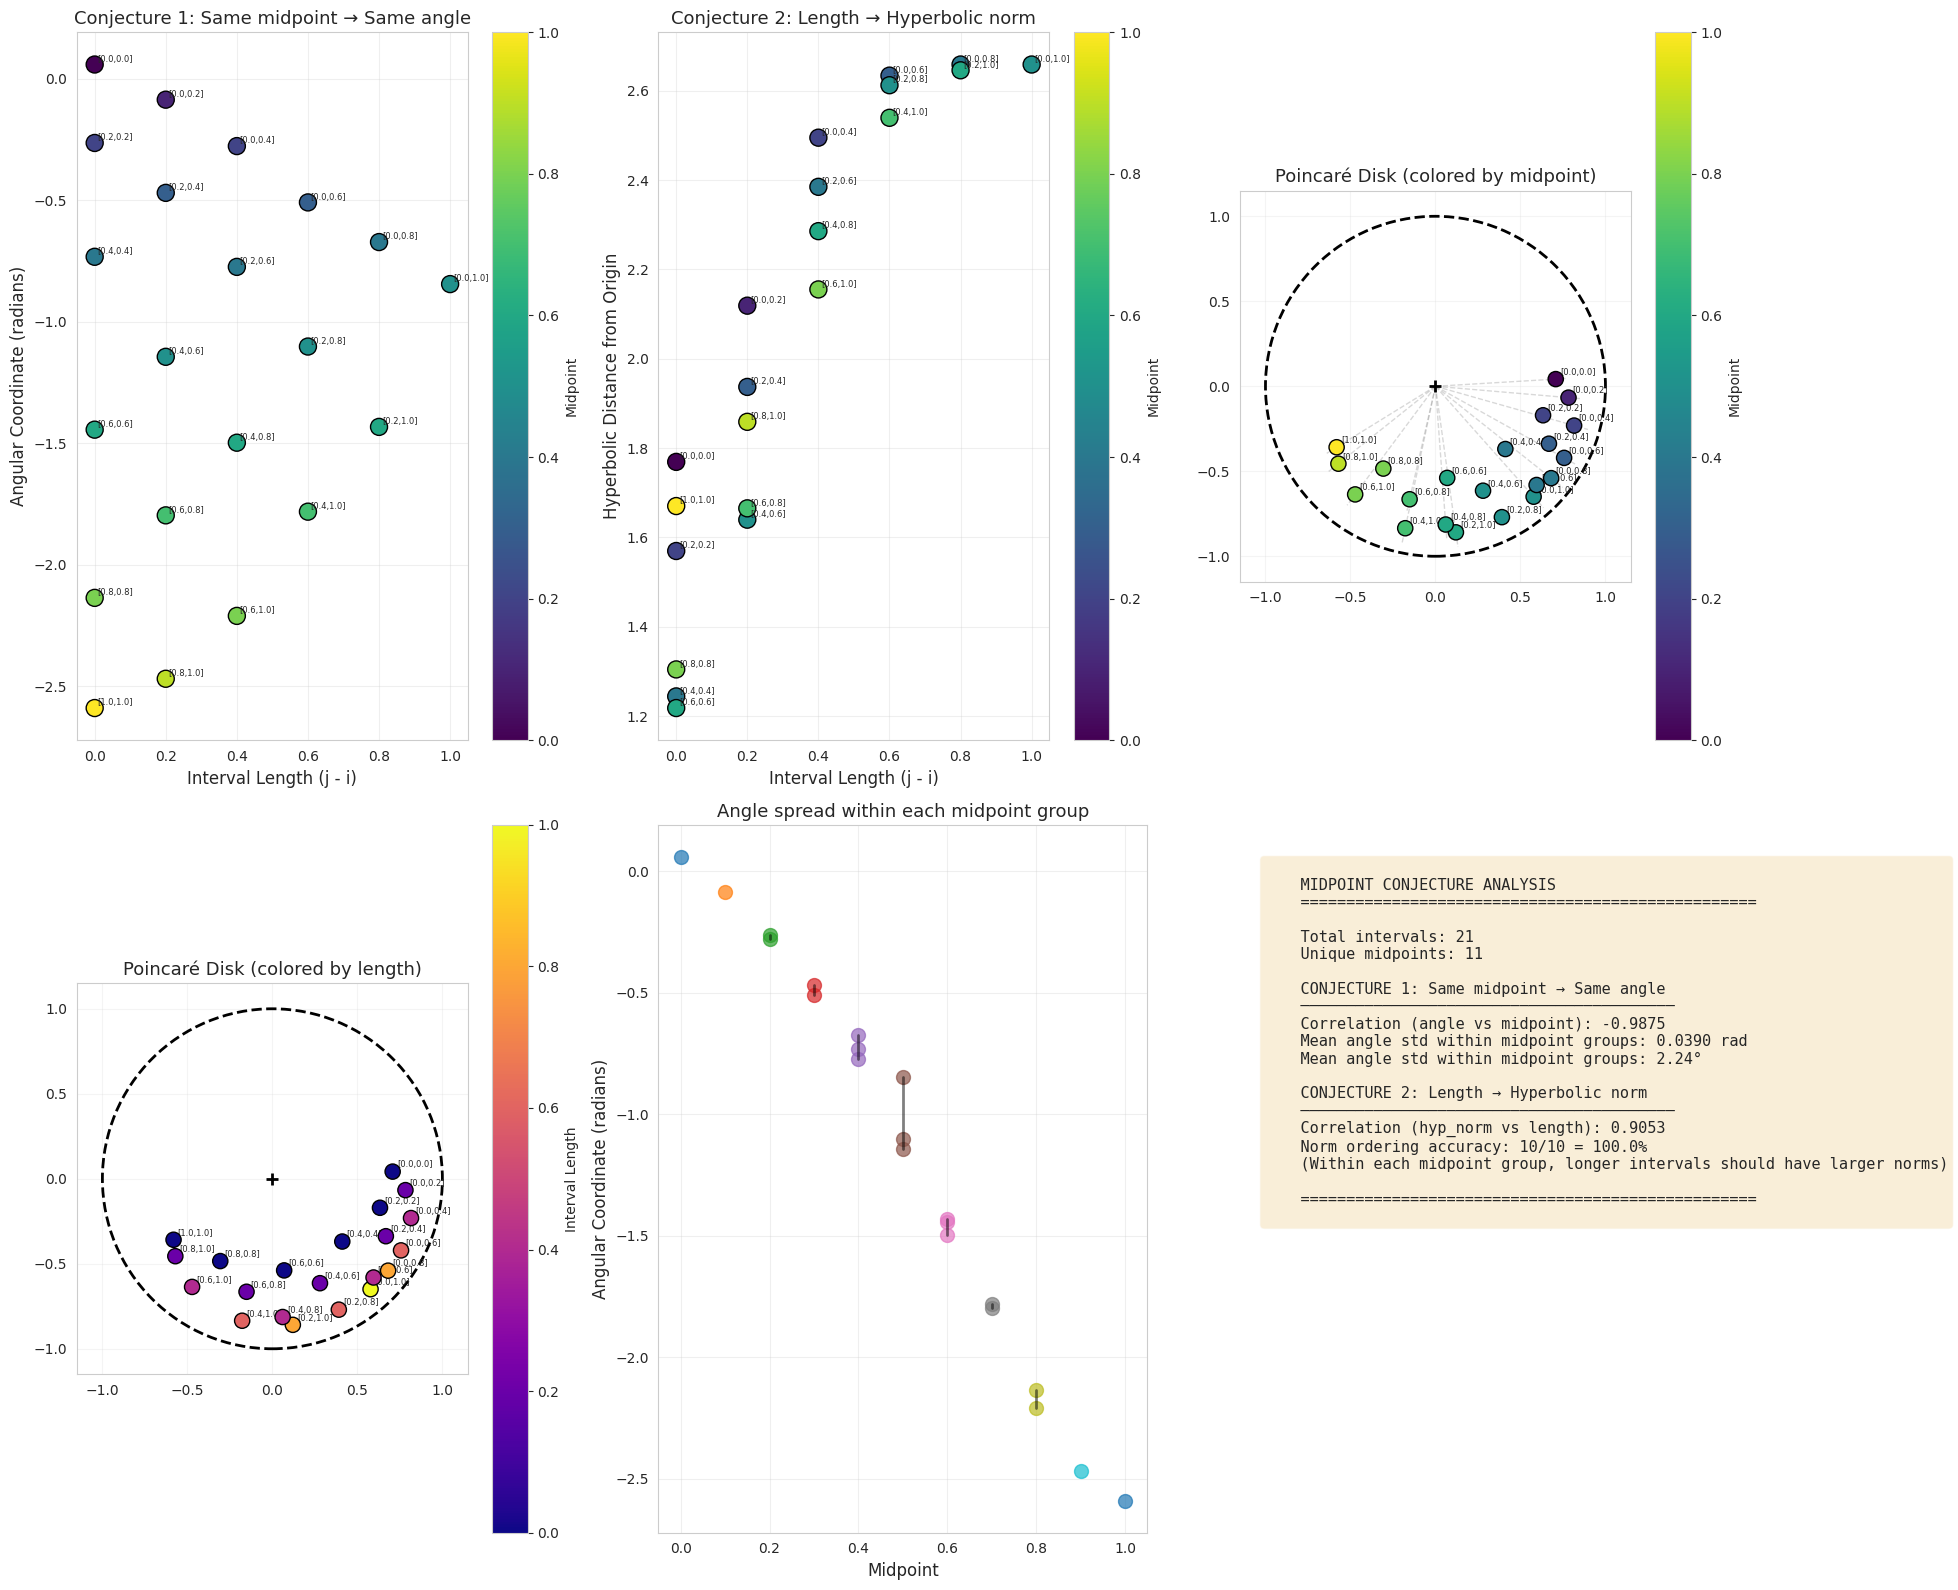

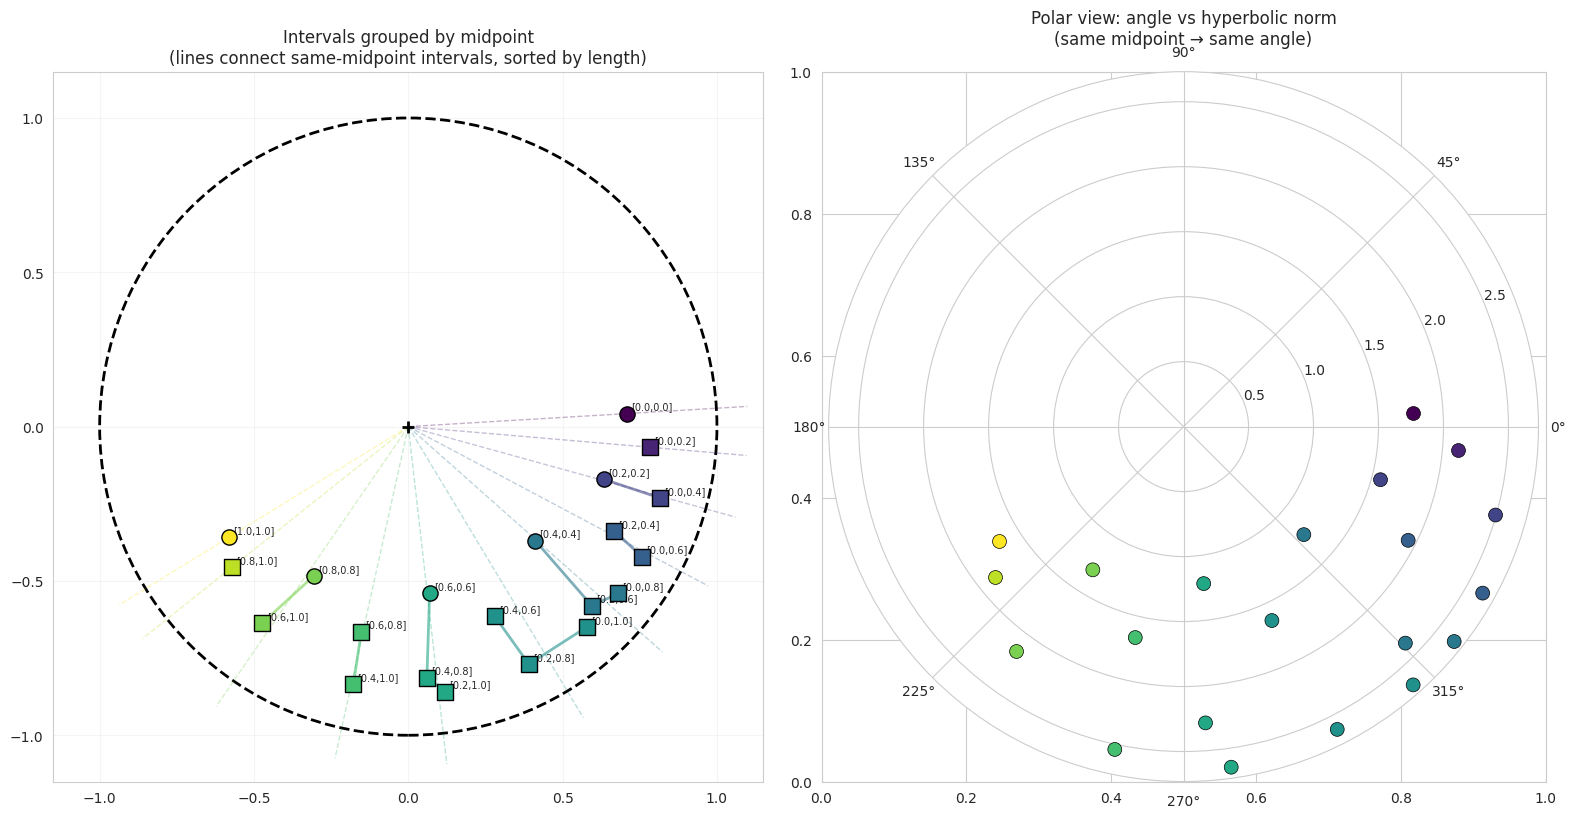


SUMMARY
Angle-Midpoint correlation: -0.9875
Norm-Length correlation: 0.9053
Mean angle std within groups: 2.24°
Norm ordering accuracy: 100.0%


In [ ]:
def analyze_midpoint_conjecture(model, num_points=5, curvature=1.0):
    """
    Test the midpoint conjecture:
    1. Intervals with the same midpoint lie at the same angle from origin
    2. Hyperbolic norm corresponds to interval length
    """
    model.eval()

    # Create grid and intervals
    grid = np.linspace(0, 1, num_points + 1)
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]

    # Embed all intervals and compute properties
    data = []
    with torch.no_grad():
        for i_idx, j_idx in intervals:
            i_val, j_val = grid[i_idx], grid[j_idx]
            interval = torch.tensor([[i_val, j_val]], dtype=torch.float32).to(device)
            emb = model(interval)
            if isinstance(emb, ManifoldTensor):
                emb = emb.tensor
            emb = emb.squeeze(0).cpu().numpy()

            midpoint = (i_val + j_val) / 2
            length = j_val - i_val
            angle = np.arctan2(emb[1], emb[0])  # Angular coordinate
            hyp_norm = hyperbolic_distance_to_origin(emb, curvature)
            euclidean_norm = np.linalg.norm(emb)

            data.append({
                'i_idx': i_idx,
                'j_idx': j_idx,
                'i_val': i_val,
                'j_val': j_val,
                'midpoint': midpoint,
                'length': length,
                'emb': emb,
                'angle': angle,
                'hyp_norm': hyp_norm,
                'euclidean_norm': euclidean_norm
            })

    return data, grid


def visualize_midpoint_conjecture(data, grid, curvature=1.0):
    """
    Create comprehensive visualizations for the midpoint conjecture.
    """
    # Extract arrays for plotting
    midpoints = np.array([d['midpoint'] for d in data])
    lengths = np.array([d['length'] for d in data])
    angles = np.array([d['angle'] for d in data])
    hyp_norms = np.array([d['hyp_norm'] for d in data])
    embeddings = np.array([d['emb'] for d in data])

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # =========================================================================
    # Plot 1: Angle vs Length, colored by Midpoint
    # =========================================================================
    ax1 = fig.add_subplot(2, 3, 1)
    scatter1 = ax1.scatter(lengths, angles, c=midpoints, cmap='viridis',
                           s=150, edgecolors='black', linewidth=1)
    plt.colorbar(scatter1, ax=ax1, label='Midpoint')
    ax1.set_xlabel('Interval Length (j - i)', fontsize=12)
    ax1.set_ylabel('Angular Coordinate (radians)', fontsize=12)
    ax1.set_title('Conjecture 1: Same midpoint → Same angle', fontsize=13)
    ax1.grid(True, alpha=0.3)

    # Add interval labels
    for d in data:
        ax1.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                     (d['length'], d['angle']),
                     fontsize=6, xytext=(2, 2), textcoords='offset points')

    # =========================================================================
    # Plot 2: Hyperbolic Norm vs Length, colored by Midpoint
    # =========================================================================
    ax2 = fig.add_subplot(2, 3, 2)
    scatter2 = ax2.scatter(lengths, hyp_norms, c=midpoints, cmap='viridis',
                           s=150, edgecolors='black', linewidth=1)
    plt.colorbar(scatter2, ax=ax2, label='Midpoint')
    ax2.set_xlabel('Interval Length (j - i)', fontsize=12)
    ax2.set_ylabel('Hyperbolic Distance from Origin', fontsize=12)
    ax2.set_title('Conjecture 2: Length → Hyperbolic norm', fontsize=13)
    ax2.grid(True, alpha=0.3)

    # Add interval labels
    for d in data:
        ax2.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                     (d['length'], d['hyp_norm']),
                     fontsize=6, xytext=(2, 2), textcoords='offset points')

    # =========================================================================
    # Plot 3: Poincaré disk colored by Midpoint
    # =========================================================================
    ax3 = fig.add_subplot(2, 3, 3)
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax3.add_patch(circle)
    ax3.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    scatter3 = ax3.scatter(embeddings[:, 0], embeddings[:, 1], c=midpoints,
                           cmap='viridis', s=120, edgecolors='black', linewidth=1, zorder=5)
    plt.colorbar(scatter3, ax=ax3, label='Midpoint')

    # Draw radial lines from origin for each unique midpoint
    unique_midpoints = np.unique(midpoints)
    for mp in unique_midpoints:
        mask = midpoints == mp
        mp_embeddings = embeddings[mask]
        if len(mp_embeddings) > 0:
            # Find furthest point to draw line through
            dists = np.linalg.norm(mp_embeddings, axis=1)
            furthest = mp_embeddings[np.argmax(dists)]
            ax3.plot([0, furthest[0] * 1.1], [0, furthest[1] * 1.1],
                    '--', alpha=0.3, linewidth=1, color='gray')

    for d in data:
        ax3.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                     (d['emb'][0], d['emb'][1]),
                     fontsize=6, xytext=(3, 3), textcoords='offset points')

    ax3.set_xlim(-1.15, 1.15)
    ax3.set_ylim(-1.15, 1.15)
    ax3.set_aspect('equal')
    ax3.set_title('Poincaré Disk (colored by midpoint)', fontsize=13)
    ax3.grid(True, alpha=0.2)

    # =========================================================================
    # Plot 4: Poincaré disk colored by Length
    # =========================================================================
    ax4 = fig.add_subplot(2, 3, 4)
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax4.add_patch(circle)
    ax4.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    scatter4 = ax4.scatter(embeddings[:, 0], embeddings[:, 1], c=lengths,
                           cmap='plasma', s=120, edgecolors='black', linewidth=1, zorder=5)
    plt.colorbar(scatter4, ax=ax4, label='Interval Length')

    for d in data:
        ax4.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                     (d['emb'][0], d['emb'][1]),
                     fontsize=6, xytext=(3, 3), textcoords='offset points')

    ax4.set_xlim(-1.15, 1.15)
    ax4.set_ylim(-1.15, 1.15)
    ax4.set_aspect('equal')
    ax4.set_title('Poincaré Disk (colored by length)', fontsize=13)
    ax4.grid(True, alpha=0.2)

    # =========================================================================
    # Plot 5: Angle consistency within midpoint groups
    # =========================================================================
    ax5 = fig.add_subplot(2, 3, 5)

    # Group by midpoint and compute angle statistics
    midpoint_angles = {}
    for d in data:
        mp = round(d['midpoint'], 4)  # Round to avoid float issues
        if mp not in midpoint_angles:
            midpoint_angles[mp] = []
        midpoint_angles[mp].append(d['angle'])

    # Plot angle spread for each midpoint
    mps = sorted(midpoint_angles.keys())
    for i, mp in enumerate(mps):
        angles_group = midpoint_angles[mp]
        ax5.scatter([mp] * len(angles_group), angles_group, s=100, alpha=0.7)
        if len(angles_group) > 1:
            ax5.plot([mp, mp], [min(angles_group), max(angles_group)], 'k-', linewidth=2, alpha=0.5)

    ax5.set_xlabel('Midpoint', fontsize=12)
    ax5.set_ylabel('Angular Coordinate (radians)', fontsize=12)
    ax5.set_title('Angle spread within each midpoint group', fontsize=13)
    ax5.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 6: Statistics summary
    # =========================================================================
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.axis('off')

    # Compute correlations
    corr_angle_midpoint = np.corrcoef(angles, midpoints)[0, 1]
    corr_norm_length = np.corrcoef(hyp_norms, lengths)[0, 1]

    # Compute angle consistency per midpoint group
    angle_stds = []
    for mp, angs in midpoint_angles.items():
        if len(angs) > 1:
            angle_stds.append(np.std(angs))
    mean_angle_std = np.mean(angle_stds) if angle_stds else 0

    # Compute norm ordering consistency per midpoint group
    norm_ordering_correct = 0
    norm_ordering_total = 0
    for mp in mps:
        group = [d for d in data if round(d['midpoint'], 4) == mp]
        if len(group) > 1:
            group_sorted_by_length = sorted(group, key=lambda x: x['length'])
            norms_in_order = [g['hyp_norm'] for g in group_sorted_by_length]
            for i in range(len(norms_in_order) - 1):
                norm_ordering_total += 1
                if norms_in_order[i] < norms_in_order[i + 1]:
                    norm_ordering_correct += 1

    norm_ordering_acc = norm_ordering_correct / norm_ordering_total if norm_ordering_total > 0 else 0

    stats_text = f"""
    MIDPOINT CONJECTURE ANALYSIS
    {'='*50}

    Total intervals: {len(data)}
    Unique midpoints: {len(mps)}

    CONJECTURE 1: Same midpoint → Same angle
    ─────────────────────────────────────────
    Correlation (angle vs midpoint): {corr_angle_midpoint:.4f}
    Mean angle std within midpoint groups: {mean_angle_std:.4f} rad
    Mean angle std within midpoint groups: {np.degrees(mean_angle_std):.2f}°

    CONJECTURE 2: Length → Hyperbolic norm
    ─────────────────────────────────────────
    Correlation (hyp_norm vs length): {corr_norm_length:.4f}
    Norm ordering accuracy: {norm_ordering_correct}/{norm_ordering_total} = {100*norm_ordering_acc:.1f}%
    (Within each midpoint group, longer intervals should have larger norms)

    {'='*50}
    """

    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('midpoint_conjecture.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {
        'corr_angle_midpoint': corr_angle_midpoint,
        'corr_norm_length': corr_norm_length,
        'mean_angle_std': mean_angle_std,
        'norm_ordering_accuracy': norm_ordering_acc
    }


def visualize_midpoint_groups(data, grid):
    """
    Detailed visualization showing intervals grouped by midpoint.
    """
    # Group by midpoint
    midpoint_groups = {}
    for d in data:
        mp = round(d['midpoint'], 4)
        if mp not in midpoint_groups:
            midpoint_groups[mp] = []
        midpoint_groups[mp].append(d)

    # Sort groups by midpoint
    sorted_mps = sorted(midpoint_groups.keys())
    n_groups = len(sorted_mps)

    # Create colormap for midpoints
    cmap = plt.cm.viridis
    colors = {mp: cmap(i / (n_groups - 1)) for i, mp in enumerate(sorted_mps)}

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # =========================================================================
    # Left: Poincaré disk with lines connecting same-midpoint intervals
    # =========================================================================
    ax = axes[0]
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

    for mp in sorted_mps:
        group = midpoint_groups[mp]
        color = colors[mp]

        # Sort by length
        group_sorted = sorted(group, key=lambda x: x['length'])

        # Draw line connecting all points in this group (sorted by length)
        if len(group_sorted) > 1:
            embs = np.array([g['emb'] for g in group_sorted])
            ax.plot(embs[:, 0], embs[:, 1], '-', color=color, linewidth=2, alpha=0.6, zorder=3)

        # Draw points
        for d in group_sorted:
            marker = 'o' if d['length'] == 0 else 's'  # Circle for atomic, square for non-atomic
            ax.scatter([d['emb'][0]], [d['emb'][1]], s=120, c=[color],
                       marker=marker, edgecolors='black', linewidth=1, zorder=5)
            ax.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                       (d['emb'][0], d['emb'][1]),
                       fontsize=7, xytext=(3, 3), textcoords='offset points')

    # Add ideal radial lines from origin
    for mp in sorted_mps:
        group = midpoint_groups[mp]
        if group:
            mean_angle = np.mean([d['angle'] for d in group])
            ax.plot([0, np.cos(mean_angle) * 1.1], [0, np.sin(mean_angle) * 1.1],
                   '--', color=colors[mp], alpha=0.3, linewidth=1, zorder=1)

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.set_title('Intervals grouped by midpoint\n(lines connect same-midpoint intervals, sorted by length)', fontsize=12)
    ax.grid(True, alpha=0.2)

    # =========================================================================
    # Right: Polar plot - angle vs hyperbolic norm
    # =========================================================================
    ax = axes[1]
    ax = fig.add_subplot(1, 2, 2, projection='polar')

    for mp in sorted_mps:
        group = midpoint_groups[mp]
        color = colors[mp]

        angles_group = [d['angle'] for d in group]
        norms_group = [d['hyp_norm'] for d in group]

        ax.scatter(angles_group, norms_group, c=[color] * len(group), s=100,
                   edgecolors='black', linewidth=0.5, label=f'mp={mp:.2f}')

    ax.set_title('Polar view: angle vs hyperbolic norm\n(same midpoint → same angle)', fontsize=12, pad=20)

    plt.tight_layout()
    plt.savefig('midpoint_groups.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_ideal_structure(data, grid):
    """
    Show what the ideal structure would look like if the conjecture held perfectly.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Extract data
    midpoints = np.array([d['midpoint'] for d in data])
    lengths = np.array([d['length'] for d in data])
    embeddings = np.array([d['emb'] for d in data])

    # =========================================================================
    # Left: Actual embeddings
    # =========================================================================
    ax = axes[0]
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)

    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=midpoints,
                         cmap='viridis', s=100, edgecolors='black', linewidth=1)
    plt.colorbar(scatter, ax=ax, label='Midpoint')

    for d in data:
        ax.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                   (d['emb'][0], d['emb'][1]),
                   fontsize=6, xytext=(2, 2), textcoords='offset points')

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.set_title('Actual Embeddings', fontsize=14)
    ax.grid(True, alpha=0.2)

    # =========================================================================
    # Middle: Ideal embeddings based on conjecture
    # =========================================================================
    ax = axes[1]
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)

    # Map midpoint to angle: midpoint in [0,1] -> angle in [0, 2π] or some range
    # Map length to radius: length in [0,1] -> radius in [0, ~0.9]
    ideal_angles = midpoints * 2 * np.pi  # Spread midpoints around the circle
    ideal_radii = lengths * 0.85 + 0.05  # Scale length to radius, keep away from boundary

    ideal_x = ideal_radii * np.cos(ideal_angles)
    ideal_y = ideal_radii * np.sin(ideal_angles)

    scatter = ax.scatter(ideal_x, ideal_y, c=midpoints,
                         cmap='viridis', s=100, edgecolors='black', linewidth=1)
    plt.colorbar(scatter, ax=ax, label='Midpoint')

    for i, d in enumerate(data):
        ax.annotate(f"[{d['i_val']:.1f},{d['j_val']:.1f}]",
                   (ideal_x[i], ideal_y[i]),
                   fontsize=6, xytext=(2, 2), textcoords='offset points')

    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.set_title('Ideal Embeddings\n(midpoint→angle, length→radius)', fontsize=14)
    ax.grid(True, alpha=0.2)

    # =========================================================================
    # Right: Deviation from ideal
    # =========================================================================
    ax = axes[2]

    # Compute actual angles and radii
    actual_angles = np.arctan2(embeddings[:, 1], embeddings[:, 0])
    actual_radii = np.linalg.norm(embeddings, axis=1)

    # Normalize angles to [0, 2π]
    actual_angles = (actual_angles + 2 * np.pi) % (2 * np.pi)
    ideal_angles_normalized = (ideal_angles + 2 * np.pi) % (2 * np.pi)

    # Compute angular deviation (handling wraparound)
    angle_diff = actual_angles - ideal_angles_normalized
    angle_diff = np.abs((angle_diff + np.pi) % (2 * np.pi) - np.pi)  # Wrap to [-π, π]

    ax.scatter(midpoints, np.degrees(angle_diff), c=lengths, cmap='plasma',
               s=100, edgecolors='black', linewidth=1)
    ax.set_xlabel('Midpoint', fontsize=12)
    ax.set_ylabel('Angular deviation from ideal (degrees)', fontsize=12)
    ax.set_title('Deviation: actual angle vs ideal angle\n(colored by length)', fontsize=14)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ideal_vs_actual.png', dpi=150, bbox_inches='tight')
    plt.show()


# Run the analysis
data, grid = analyze_midpoint_conjecture(model, num_points=5, curvature=1.0)
stats = visualize_midpoint_conjecture(data, grid, curvature=1.0)
visualize_midpoint_groups(data, grid)
#visualize_ideal_structure(data, grid)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Angle-Midpoint correlation: {stats['corr_angle_midpoint']:.4f}")
print(f"Norm-Length correlation: {stats['corr_norm_length']:.4f}")
print(f"Mean angle std within groups: {np.degrees(stats['mean_angle_std']):.2f}°")
print(f"Norm ordering accuracy: {100*stats['norm_ordering_accuracy']:.1f}%")

In [ ]:
class IntervalDatasetInverted(Dataset):
    """
    Inverted: anchor is the CHILD (subinterval), positive is the PARENT.
    This should place larger intervals (closer to root) near the origin.
    """

    def __init__(self, num_samples=10000, num_negatives=5, num_points=100, seed=0):
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.num_samples = num_samples
        self.num_negatives = num_negatives
        self.grid = torch.linspace(0, 1, num_points)

        self.anchors = []
        self.positives = []
        self.negatives_list = []

        for _ in range(num_samples):
            # Sample a random interval as anchor
            j_idx = torch.randint(0, num_points, (1,)).item()
            i_idx = torch.randint(0, j_idx + 1, (1,)).item()

            i_anchor = self.grid[i_idx].item()
            j_anchor = self.grid[j_idx].item()

            # Positive is a PARENT (superinterval) of anchor
            # i_pos <= i_anchor <= j_anchor <= j_pos
            i_pos_idx = torch.randint(0, i_idx + 1, (1,)).item()
            j_pos_idx = torch.randint(j_idx, num_points, (1,)).item()

            i_pos = self.grid[i_pos_idx].item()
            j_pos = self.grid[j_pos_idx].item()

            # Negatives: intervals that do NOT contain the anchor
            negatives = []
            for _ in range(num_negatives):
                j_neg_idx = torch.randint(0, num_points, (1,)).item()
                i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()

                # Valid negative: NOT a superinterval of anchor
                # Must violate: i_neg <= i_anchor AND j_anchor <= j_neg
                max_attempts = 100
                attempt = 0
                while (i_neg_idx <= i_idx and j_idx <= j_neg_idx) and attempt < max_attempts:
                    j_neg_idx = torch.randint(0, num_points, (1,)).item()
                    i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()
                    attempt += 1

                negatives.append([self.grid[i_neg_idx].item(), self.grid[j_neg_idx].item()])

            self.anchors.append([i_anchor, j_anchor])
            self.positives.append([i_pos, j_pos])
            self.negatives_list.append(negatives)

        self.anchors = torch.tensor(self.anchors, dtype=torch.float32)
        self.positives = torch.tensor(self.positives, dtype=torch.float32)
        self.negatives_list = torch.tensor(self.negatives_list, dtype=torch.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.anchors[idx], self.positives[idx], self.negatives_list[idx]

In [ ]:
def compare_structures(model_original, model_inverted, num_points=5):
    """Compare the two embedding structures."""

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    grid = np.linspace(0, 1, num_points + 1)
    intervals = [(i, j) for i in range(num_points + 1) for j in range(i, num_points + 1)]

    for ax, model, title in [(axes[0], model_original, 'Original (child→origin)'),
                              (axes[1], model_inverted, 'Inverted (parent→origin)')]:
        model.eval()

        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.scatter([0], [0], s=80, c='black', marker='+', linewidth=2, zorder=10)

        embeddings = []
        lengths = []
        with torch.no_grad():
            for i_idx, j_idx in intervals:
                i_val, j_val = grid[i_idx], grid[j_idx]
                interval = torch.tensor([[i_val, j_val]], dtype=torch.float32).to(device)
                emb = model(interval)
                if isinstance(emb, ManifoldTensor):
                    emb = emb.tensor
                emb = emb.squeeze(0).cpu().numpy()
                embeddings.append(emb)
                lengths.append(j_val - i_val)

        embeddings = np.array(embeddings)
        lengths = np.array(lengths)

        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=lengths,
                            cmap='plasma', s=100, edgecolors='black', linewidth=1)
        plt.colorbar(scatter, ax=ax, label='Interval Length')

        # Label key intervals
        for idx, (i_idx, j_idx) in enumerate(intervals):
            i_val, j_val = grid[i_idx], grid[j_idx]
            if (i_idx == j_idx) or (i_idx == 0 and j_idx == num_points):  # Singletons and [0,1]
                label = f"[{i_val:.1f},{j_val:.1f}]"
                ax.annotate(label, embeddings[idx], fontsize=7, xytext=(3, 3),
                           textcoords='offset points', fontweight='bold')

        ax.set_xlim(-1.15, 1.15)
        ax.set_ylim(-1.15, 1.15)
        ax.set_aspect('equal')
        ax.set_title(title, fontsize=14)
        ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.savefig('structure_comparison.png', dpi=150)
    plt.show()


# Train with inverted dataset
dataset_inverted = IntervalDatasetInverted(num_samples=1000, num_negatives=2, num_points=10, seed=42)
model_inverted = HyperbolicIntervalEncoder(
    embedding_dim=2,
    c=1.0,
    euc_width=128,
    hyp_width=128
).to(device)

losses_inverted = train_model(model_inverted, dataset_inverted, num_epochs=200, batch_size=32, lr=0.001, temperature=0.1)

Epoch 5/200, Loss: 0.4345
Epoch 10/200, Loss: 0.3894
Epoch 15/200, Loss: 0.3594
Epoch 20/200, Loss: 0.3174
Epoch 25/200, Loss: 0.3158
Epoch 30/200, Loss: 0.3206
Epoch 35/200, Loss: 0.2663
Epoch 40/200, Loss: 0.1635
Epoch 45/200, Loss: 0.1290
Epoch 50/200, Loss: 0.0611
Epoch 55/200, Loss: 0.0856
Epoch 60/200, Loss: 0.0757
Epoch 65/200, Loss: 0.0656
Epoch 70/200, Loss: 0.0623
Epoch 75/200, Loss: 0.0387
Epoch 80/200, Loss: 0.0604
Epoch 85/200, Loss: 0.0660
Epoch 90/200, Loss: 0.0463
Epoch 95/200, Loss: 0.0343
Epoch 100/200, Loss: 0.0373
Epoch 105/200, Loss: 0.0329
Epoch 110/200, Loss: 0.0325
Epoch 115/200, Loss: 0.0269
Epoch 120/200, Loss: 0.0282
Epoch 125/200, Loss: 0.0281
Epoch 130/200, Loss: 0.0285
Epoch 135/200, Loss: 0.0295
Epoch 140/200, Loss: 0.0272
Epoch 145/200, Loss: 0.0284
Epoch 150/200, Loss: 0.0285
Epoch 155/200, Loss: 0.0272
Epoch 160/200, Loss: 0.0308
Epoch 165/200, Loss: 0.0273
Epoch 170/200, Loss: 0.0265
Epoch 175/200, Loss: 0.0269
Epoch 180/200, Loss: 0.0264
Epoch 185/20

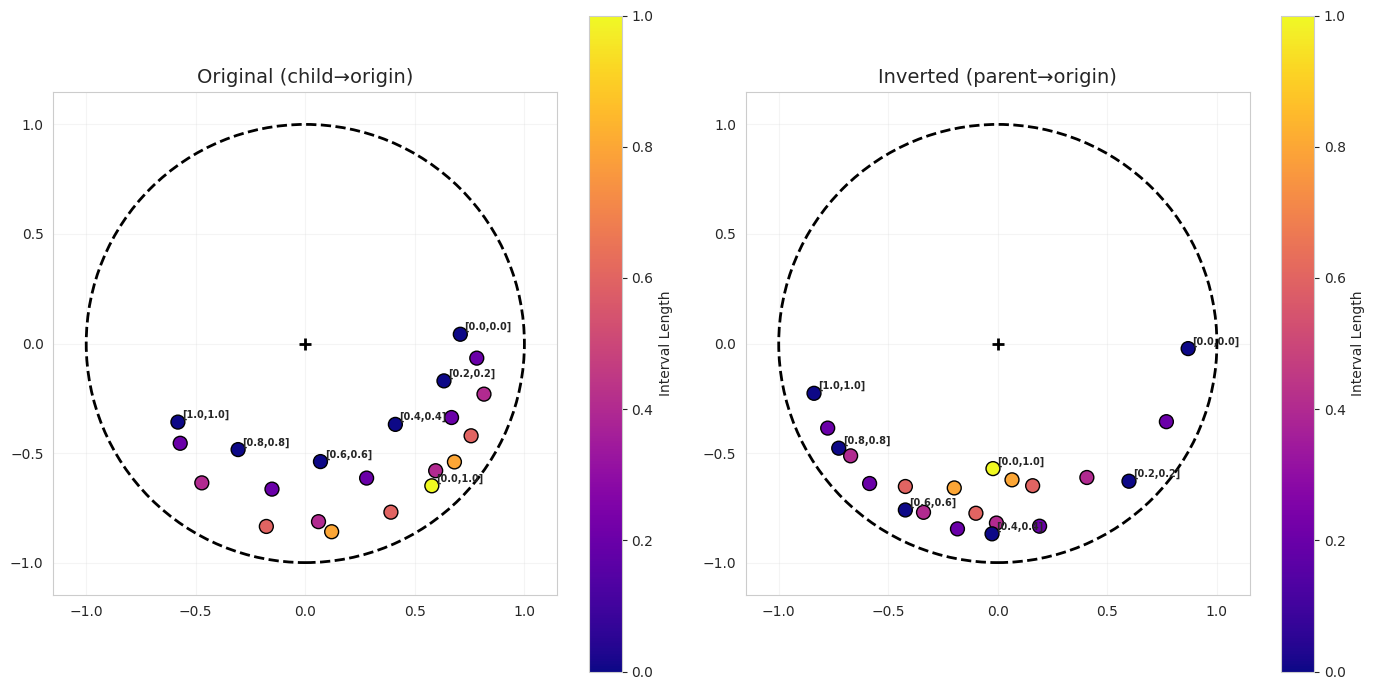

In [ ]:
# Compare
compare_structures(model, model_inverted, num_points=5)

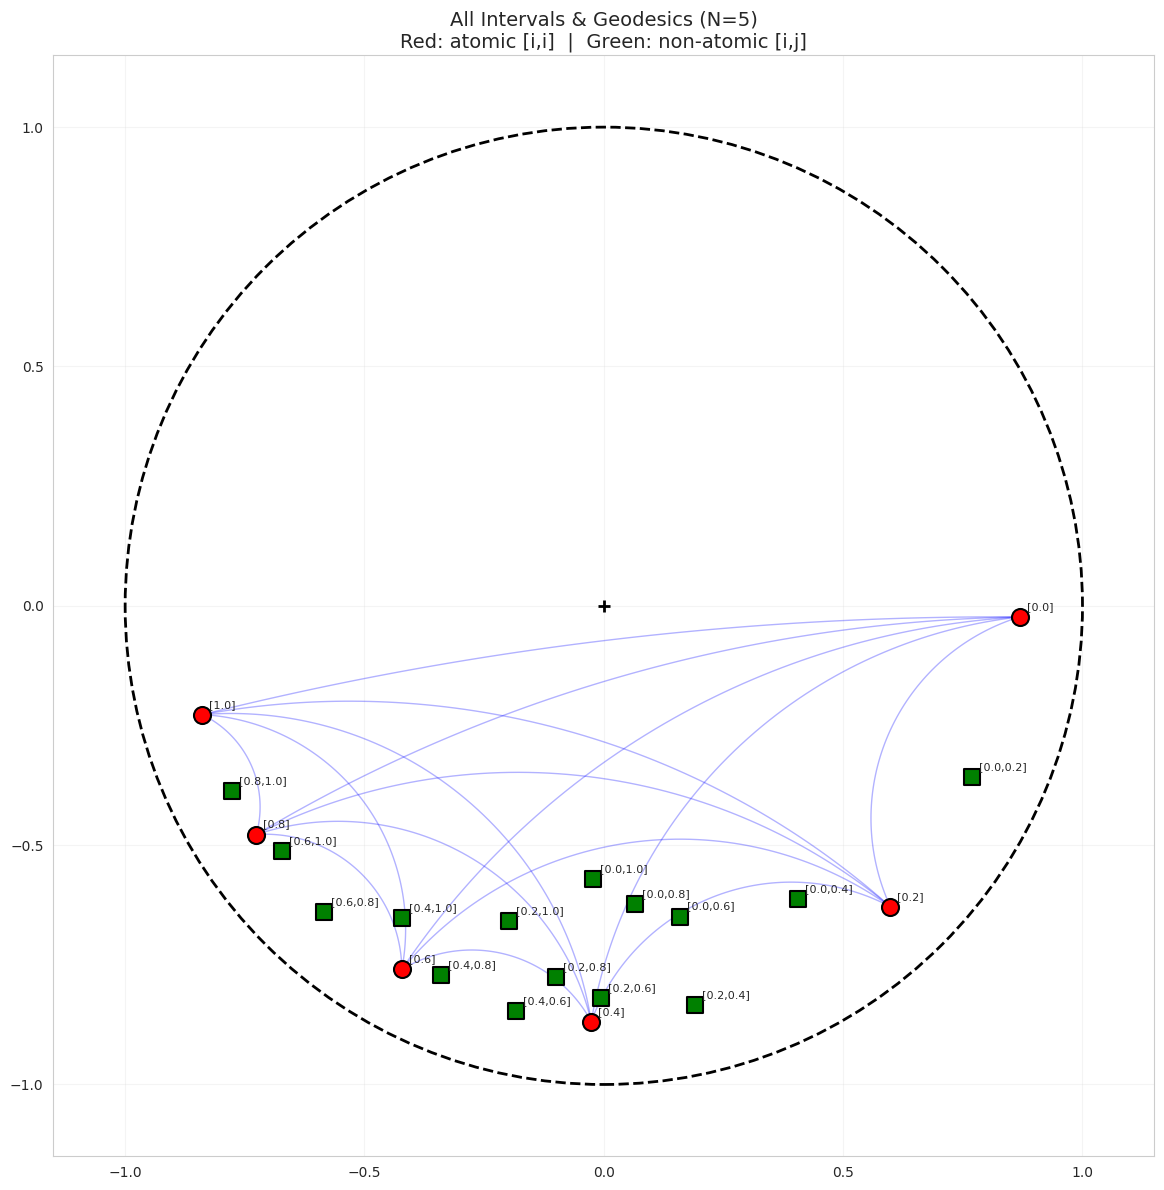

In [ ]:
embeddings_inverted = plot_all_intervals_with_geodesics(model_inverted, num_points=5)

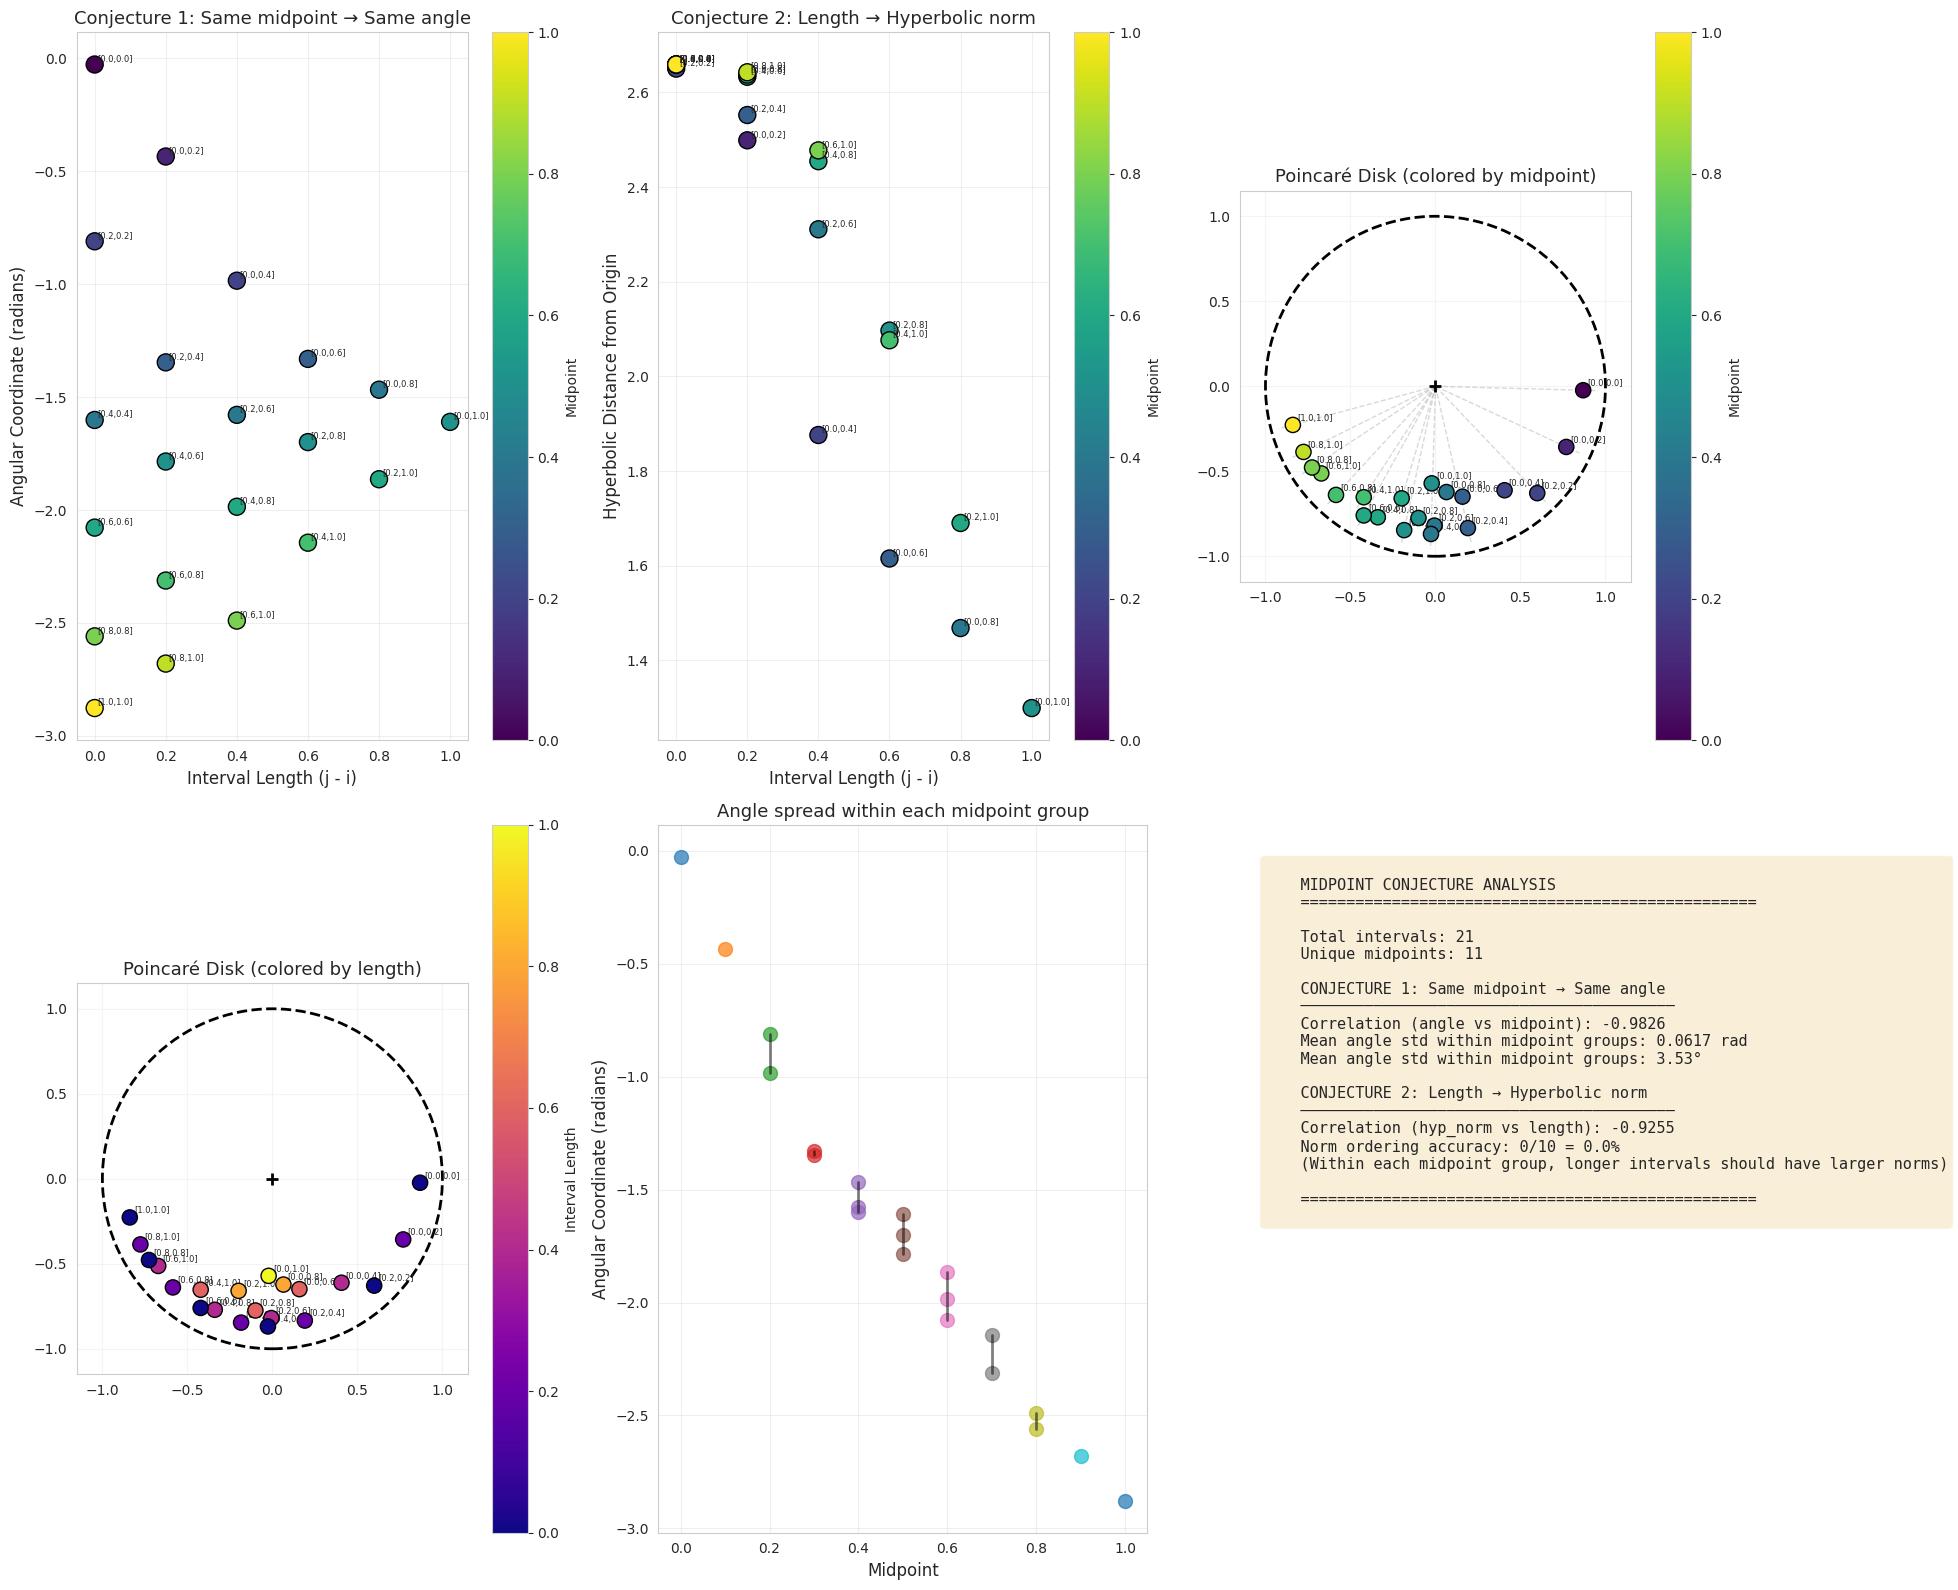

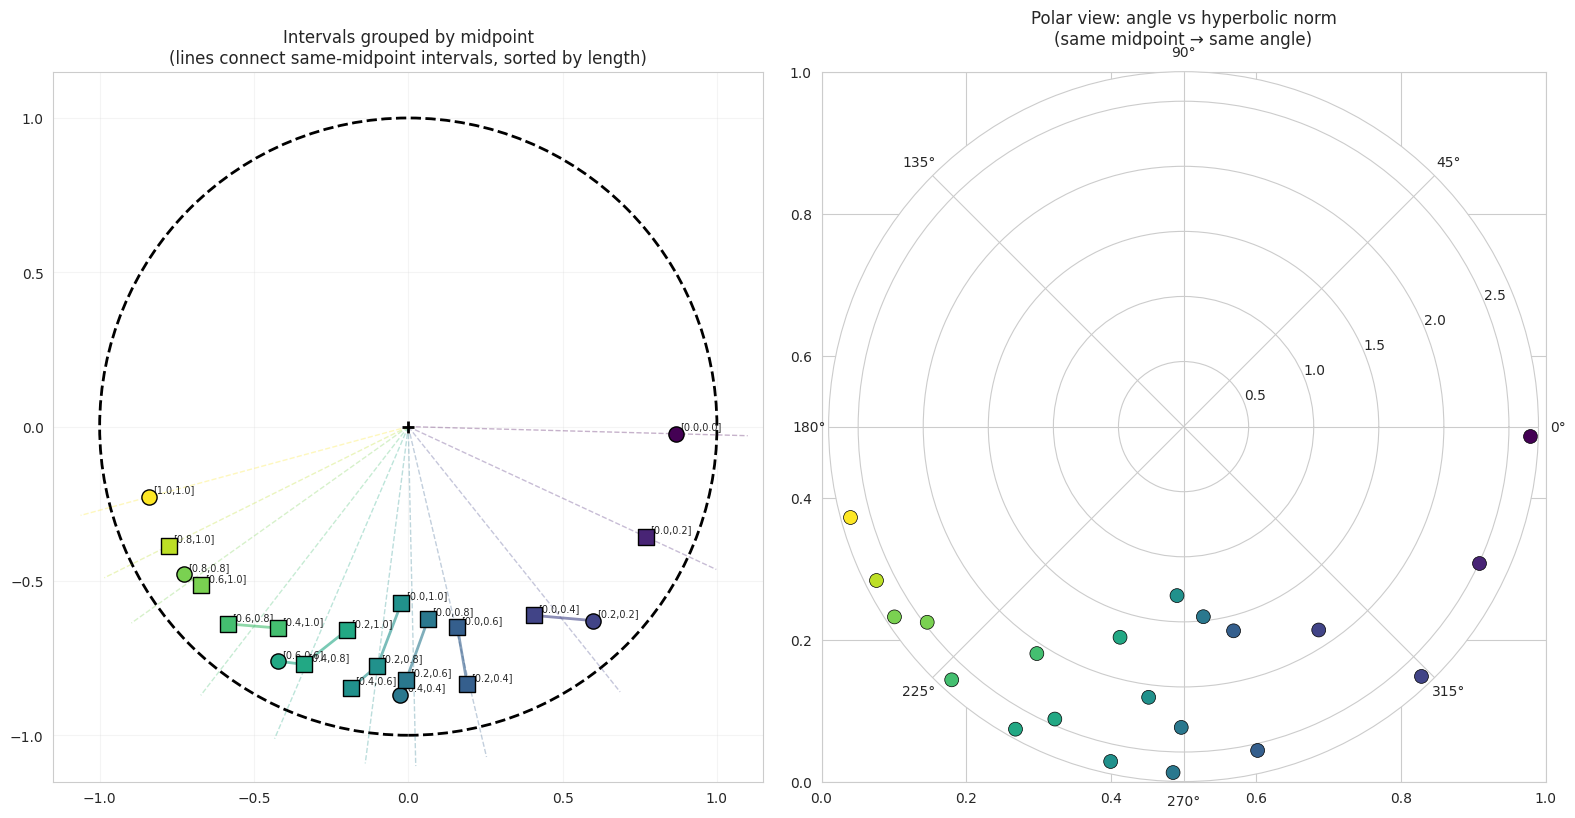


SUMMARY
Angle-Midpoint correlation: -0.9826
Norm-Length correlation: -0.9255
Mean angle std within groups: 3.53°
Norm ordering accuracy: 0.0%


In [ ]:
# Run the analysis
data_inverted, grid_inverted = analyze_midpoint_conjecture(model_inverted, num_points=5, curvature=1.0)
stats_inverted = visualize_midpoint_conjecture(data_inverted, grid_inverted, curvature=1.0)
visualize_midpoint_groups(data_inverted, grid_inverted)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Angle-Midpoint correlation: {stats_inverted['corr_angle_midpoint']:.4f}")
print(f"Norm-Length correlation: {stats_inverted['corr_norm_length']:.4f}")
print(f"Mean angle std within groups: {np.degrees(stats_inverted['mean_angle_std']):.2f}°")
print(f"Norm ordering accuracy: {100*stats_inverted['norm_ordering_accuracy']:.1f}%")

In [ ]:
class TemporalIntervalDataset(Dataset):
    """
    Learn φ(i, j, t) where t ∈ [0, 1] indexes position along the interval.

    The representation should capture:
    - Midpoint of the "remaining" interval at time t
    - Length/uncertainty of the remaining interval
    """

    def __init__(self, num_samples=10000, num_negatives=5, num_points=100, seed=0):
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.num_samples = num_samples
        self.num_negatives = num_negatives
        self.grid = torch.linspace(0, 1, num_points)

        self.anchors = []      # (i, j, t)
        self.positives = []    # Subinterval at time t
        self.negatives_list = []

        for _ in range(num_samples):
            # Sample interval [i, j]
            j_idx = torch.randint(1, num_points, (1,)).item()
            i_idx = torch.randint(0, j_idx, (1,)).item()

            i, j = self.grid[i_idx].item(), self.grid[j_idx].item()

            # Sample time t ∈ [0, 1]
            t = torch.rand(1).item()

            # The "current position" at time t is: pos_t = i + t * (j - i)
            pos_t = i + t * (j - i)

            # Positive: subinterval containing pos_t
            # This models "remaining uncertainty" at time t
            i_pos = i + torch.rand(1).item() * (pos_t - i)
            j_pos = pos_t + torch.rand(1).item() * (j - pos_t)
            t_pos = (pos_t - i_pos) / (j_pos - i_pos + 1e-8)  # Relative time in subinterval

            # Negatives: intervals that don't contain pos_t
            negatives = self._sample_negatives(i_idx, j_idx, pos_t, num_points)

            self.anchors.append([i, j, t])
            self.positives.append([i_pos, j_pos, t_pos])
            self.negatives_list.append(negatives)

        self.anchors = torch.tensor(self.anchors, dtype=torch.float32)
        self.positives = torch.tensor(self.positives, dtype=torch.float32)
        self.negatives_list = torch.tensor(self.negatives_list, dtype=torch.float32)

    def _sample_negatives(self, i_idx, j_idx, pos_t, num_points):
        negatives = []
        for _ in range(self.num_negatives):
            # Sample interval that doesn't contain pos_t
            j_neg_idx = torch.randint(0, num_points, (1,)).item()
            i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()
            i_neg, j_neg = self.grid[i_neg_idx].item(), self.grid[j_neg_idx].item()

            max_attempts = 100
            attempt = 0
            while i_neg <= pos_t <= j_neg and attempt < max_attempts:
                j_neg_idx = torch.randint(0, num_points, (1,)).item()
                i_neg_idx = torch.randint(0, j_neg_idx + 1, (1,)).item()
                i_neg, j_neg = self.grid[i_neg_idx].item(), self.grid[j_neg_idx].item()
                attempt += 1

            t_neg = torch.rand(1).item()
            negatives.append([i_neg, j_neg, t_neg])

        return negatives

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.anchors[idx], self.positives[idx], self.negatives_list[idx]